In [67]:
import numpy as np
import pandas as pd
import sklearn
import scipy
from scipy.spatial import Delaunay
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import collections
from collections import defaultdict
from Geometry3D import *
import copy
import random
import itertools
from scipy.stats import truncnorm
from scipy.stats import bernoulli
import math
import shapely
from shapely.geometry import Point as pointpoint
from shapely.geometry.polygon import Polygon as polygonpolygon
from shapely.geometry import MultiPolygon
from itertools import permutations
import shapely.geometry as sg
import pandas as pd
import time
import json
epsilon = 10e-7
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

# Helpful functions

In [2]:
#Binary function that 
#- returns "True" if edges are parallel or coincide
#- returns "False" if not

# a = [7/3, 1, 2, 0, 0, 1]
# b = [2, 0, 0, 1, 0, 2]

def parallelism(a, b):
    
    if np.abs((a[0] - a[2])*(b[1] - b[3]) - (a[1] - a[3])*(b[0] - b[2])) < epsilon:
        
        return True
    
    else:
        
        return False

In [3]:
#Intersection point of two edges or their continuations

#a = [3, 3, 0, 1, 0, 1]
#b = [2, 1, 1, 1, 0, 2]

def edges_intersection(a, b):
    
    return [((a[0]*a[3] - a[1]*a[2])*(b[0] - b[2])-(a[0] - a[2])*(b[0]*b[3] - b[1]*b[2]))/ \
            ((a[0] - a[2])*(b[1] - b[3])-(a[1]-a[3])*(b[0] - b[2])), \
            (((a[0]*a[3] - a[1]*a[2])*(b[1] - b[3])-(a[1] - a[3])*(b[0]*b[3] - b[1]*b[2]))/ \
            ((a[0] - a[2])*(b[1] - b[3])-(a[1]-a[3])*(b[0] - b[2])))]

In [4]:
#Binary function that
#- returns "True" if edges a and b are not parallel and intersect in the interior of any of edges
#- returns "False" if edges are parallel or don't intersection or it's intersection - common vertex 

# a = [4, 2, 5, 3, 3, 0] 
# b = [2.3476259661391095, 1.026174593643856, 5, 3, 3, 6]

def intersection_inmid(a, b):

    if parallelism(a, b) == True:
        
        return False
    
    else:
        
        #p - intersection of edges'cintinuations
        p = edges_intersection(a, b)

        if (((p[0] - a[0] > epsilon) and (a[2] - p[0] > epsilon)) or ((a[0] - p[0] > epsilon) and (p[0] - a[2] > epsilon)) or\
            ((np.abs(p[0] - a[0]) < epsilon) and (np.abs(p[0] - a[2]) < epsilon))) and\
    (((p[0] - b[0] > epsilon) and (b[2] - p[0] > epsilon)) or ((b[0] - p[0] > epsilon) and (p[0] - b[2] > epsilon)) or\
     ((np.abs(p[0] - b[0]) < epsilon) and (np.abs(p[0] - b[2]) < epsilon))) and\
    (((p[1] - a[1] > epsilon) and (a[3] - p[1] > epsilon)) or ((a[1] - p[1] > epsilon) and (p[1] - a[3] > epsilon)) or\
     ((np.abs(p[1] - a[1]) < epsilon) and (np.abs(p[1] - a[3]) < epsilon))) and\
    (((p[1] - b[1] > epsilon) and (b[3] - p[1] > epsilon)) or ((b[1] - p[1] > epsilon) and (p[1] - b[3] > epsilon)) or\
     ((np.abs(p[1] - b[1]) < epsilon) and (np.abs(p[1] - b[3]) < epsilon))):
            
            return True
        
        else:
            
            return False

In [5]:
#Number of unique levels including 0

def nlevels(poly):
    return len(np.unique([i[3] for i in poly]))

In [6]:
#Number of non-zero spaces in poly

def nspaces(poly):
    
    #list_spaces: [1 2 3]
    list_spaces = np.unique([i[4] for i in poly])

    if 0 in list_spaces:
        nspaces = len(list_spaces) - 1
    else:
        nspaces = len(list_spaces)
    
    return nspaces

In [7]:
def v(poly):
    v = defaultdict(list)
    for i in range(nlevels(poly)):
        for j in poly:
            if j[3] == i:
                if [x for y in [j[0], [i], [j[4]]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[0], [i], [j[4]]] for x in y])
                if [x for y in [j[1], [i], [j[4]]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[1], [i], [j[4]]] for x in y])
                if [x for y in [j[2], [i], [j[4]]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[2], [i], [j[4]]] for x in y])
    return v

In [8]:
#unique vertices on the level

def unique_v(poly):
    v = defaultdict(list)
    for i in range(nlevels(poly)):
        for j in poly:
            if j[3] == i:
                if [x for y in [j[0], [i]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[0], [i]] for x in y])
                if [x for y in [j[1], [i]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[1], [i]] for x in y])
                if [x for y in [j[2], [i]] for x in y] not in v[i]:
                    v[i].append([x for y in [j[2], [i]] for x in y])
    return v

In [9]:
def e(poly):
    e = defaultdict(list)
    for i in range(nlevels(poly)):
        for j in poly:
            if j[3] == i:
                if ([j[0], j[1], i, j[4]] not in e[i]) and ([j[1], j[0], i, j[4]] not in e[i]):
                    e[i].append([x for y in [j[0], j[1], [i], [j[4]]] for x in y])
                if ([j[1], j[2], i, j[4]] not in e[i]) and ([j[2], j[1], i, j[4]] not in e[i]):
                    e[i].append([x for y in [j[1], j[2], [i], [j[4]]] for x in y])
                if ([j[0], j[2], i, j[4]] not in e[i]) and ([j[2], j[0], i, j[4]] not in e[i]):
                    e[i].append([x for y in [j[0], j[2], [i], [j[4]]] for x in y])
    return e

In [10]:
#unique edges on the level

def unique_e(poly):
    
    e = defaultdict(list)
    
    #i - level including zero and maximal level
    for i in range(nlevels(poly)):
        
        #j - cell on level i
        for j in poly:
            if j[3] == i:
                
                #To key i we add value [0, 0, 2, 0, level] if it's not already in e
                if ([x for y in [j[0], j[1], [i]] for x in y] not in e[i]) and ([x for y in [j[1], j[0], [i]] for x in y] not in e[i]):
                    e[i].append([x for y in [j[0], j[1], [i]] for x in y])
                if ([x for y in [j[1], j[2], [i]] for x in y] not in e[i]) and ([x for y in [j[2], j[1], [i]] for x in y] not in e[i]):
                    e[i].append([x for y in [j[1], j[2], [i]] for x in y])
                if ([x for y in [j[0], j[2], [i]] for x in y] not in e[i]) and ([x for y in [j[2], j[0], [i]] for x in y] not in e[i]):
                    e[i].append([x for y in [j[0], j[2], [i]] for x in y])
    return e

In [11]:
def spaces_cells(poly):
    s = defaultdict(list)
    for i in range(nspaces(poly)+1):
        for j in poly:
            if j[4] == i:
                s[i].append(j)
    return s

In [12]:
def spaces_edges(poly):
    
    #s - return of the function:  space 3: edges [[0, 0, 1, 0, 1, 3], ...]
    s = defaultdict(list)
    
    #i goes through all occuring space numbers
    for i in np.unique([u[4] for u in poly]):

        #j - cells related to space i
        for j in poly:
            if j[4] == i:
                
                s[i].append([x for y in [j[0], j[1], [j[3]], [i]] for x in y])
                s[i].append([x for y in [j[1], j[2], [j[3]], [i]] for x in y])
                s[i].append([x for y in [j[0], j[2], [j[3]], [i]] for x in y])
        
    return s

In [14]:
def ext_edges_spaces(poly):
    
    #s - space 3: edges [[0, 0, 1, 0, 1, 3], ...]
    s = spaces_edges(poly)
    
    #k - space number
    for k in s:
            
        #List of indices - internal edges of space k, i.e. edges which occur more than once 
        r = []
            
        #i, j  - two different edges in space k
        for i in range(len(s[k])):
            for j in range(len(s[k])):
                if i<j:

                    #If i = j or just vertices are swapped (the edge occured twice) => add i and j to "bad" indices 
                    if ((np.abs(s[k][i][0] - s[k][j][0]) < epsilon) and (np.abs(s[k][i][1] - s[k][j][1]) < epsilon) and\
                    (np.abs(s[k][i][2] - s[k][j][2]) < epsilon) and (np.abs(s[k][i][3] - s[k][j][3]) < epsilon) and\
                    (np.abs(s[k][i][4] - s[k][j][4]) < epsilon) and (np.abs(s[k][i][5] - s[k][j][5]) < epsilon)) or \
                    ((np.abs(s[k][i][0] - s[k][j][2]) < epsilon) and (np.abs(s[k][i][1] - s[k][j][3]) < epsilon) and\
                    (np.abs(s[k][i][2] - s[k][j][0]) < epsilon) and (np.abs(s[k][i][3] - s[k][j][1]) < epsilon) and\
                    (np.abs(s[k][i][4] - s[k][j][4]) < epsilon) and (np.abs(s[k][i][5] - s[k][j][5]) < epsilon)):
                        r.append(i)
                        r.append(j)
            
        #Delete all internal edges from the list
        s[k] = np.delete(s[k], r, axis = 0)
            
        #List of indices - edges which continue each other ("bad") and should be replaces with one edge 
        r = []
            
        #v, u - two not "bad" parallel external edges
        for v in range(len(s[k])):
            for u in range(len(s[k])):
                if (v < u) and (parallelism(s[k][v], s[k][u]) == True) and (u not in r) and (v not in r):
                        
                    #Four possible option for parallel edges to continue each other (one vertex must coincide)
                    if ((np.abs(s[k][u][0] - s[k][v][0]) < epsilon) and (np.abs(s[k][u][1] - s[k][v][1]) < epsilon) and
                        (np.abs(s[k][u][4] - s[k][v][4]) < epsilon) and (np.abs(s[k][u][5] - s[k][v][5]) < epsilon)) :

                        #Add good big edge
                        s[k] = np.vstack((s[k], [s[k][v][2], s[k][v][3], s[k][u][2], s[k][u][3], s[k][v][4], s[k][v][5]]))
                            
                        #Add "bad"edges to list r for removal 
                        r.append(u)
                        r.append(v)
                            
                    elif ((np.abs(s[k][u][0] - s[k][v][2]) < epsilon) and (np.abs(s[k][u][1] - s[k][v][3]) < epsilon) and\
                          (np.abs(s[k][u][4] - s[k][v][4]) < epsilon) and (np.abs(s[k][u][5] - s[k][v][5]) < epsilon)):
                            
                        s[k] = np.vstack((s[k], [s[k][v][0], s[k][v][1], s[k][u][2], s[k][u][3], s[k][v][4], s[k][v][5]]))
                        r.append(u)
                        r.append(v)
                            
                    elif ((np.abs(s[k][u][2] - s[k][v][2]) < epsilon) and (np.abs(s[k][u][3] - s[k][v][3]) < epsilon) and\
                          (np.abs(s[k][u][4] - s[k][v][4]) < epsilon) and (np.abs(s[k][u][5] - s[k][v][5]) < epsilon)):
                            
                        s[k] = np.vstack((s[k], [s[k][v][0], s[k][v][1], s[k][u][0], s[k][u][1], s[k][v][4], s[k][v][5]]))
                        r.append(u)
                        r.append(v)
                            
                    elif ((np.abs(s[k][u][2] - s[k][v][0]) < epsilon) and (np.abs(s[k][u][3] - s[k][v][1]) < epsilon) and\
                          (np.abs(s[k][u][4] - s[k][v][4]) < epsilon) and (np.abs(s[k][u][5] - s[k][v][5]) < epsilon)):
                        
                        s[k] = np.vstack((s[k], [s[k][v][2], s[k][v][3], s[k][u][0], s[k][u][1], s[k][v][4], s[k][v][5]]))
                        r.append(u)
                        r.append(v)
            
        #Delete all extra edges
        s[k] = np.delete(s[k], r, axis = 0)
        
    return s


In [15]:
def spacesbylevel(poly):
    s = defaultdict(list)
    for i in range(nlevels(poly)):
        for j in poly:
            if j[3] == i:
                s[i].append(j)
    return s

In [16]:
# Order point in clockwise order

def f(origin, refvec):
    def clockwiseangle_and_distance(point):
    
        # Vector between point and the origin: v = p - o
        vector = [point[0]-origin[0], point[1]-origin[1]]
        # Length of vector: ||v||
        lenvector = math.hypot(vector[0], vector[1])
        # If length is zero there is no angle
        if lenvector == 0:
            return -math.pi, 0
        # Normalize vector: v/||v||
        normalized = [vector[0]/lenvector, vector[1]/lenvector]
        dotprod  = normalized[0]*refvec[0] + normalized[1]*refvec[1]     # x1*x2 + y1*y2
        diffprod = refvec[1]*normalized[0] - refvec[0]*normalized[1]     # x1*y2 - y1*x2
        angle = math.atan2(diffprod, dotprod)
        # Negative angles represent counter-clockwise angles so we need to subtract them 
        # from 2*pi (360 degrees)
        if angle < 0:
            return 2*math.pi+angle, lenvector
        # I return first the angle because that's the primary sorting criterium
        # but if two vectors have the same angle then the shorter distance should come first.
        return angle, lenvector
    return clockwiseangle_and_distance

In [18]:
#Vizualization of one building design

def vis_poly(poly):
    n = 1
    colors = ['white', 'thistle', 'cornflowerblue', "skyblue", "pink", "mediumslateblue", "lightseagreen", 'plum', 'lightsteelblue', 'paleturquoise']

    for l in range(nlevels(poly)):

        plt.figure(figsize=(5,7))
        plt.subplot(int(str(nlevels(poly)) + str(1) + str(n)))

        m = 0

        #A = all cells on level l 
        A = []
        for i in poly:
            if i[3] == l:
                m+=1
                A.append(i)


        for t in range(nspaces(poly)+1):
            

            #r - list of polygons 
            r = []
            for i in range(len(A)):
                if A[i][4] == t:
                    r.append(sg.Polygon([(A[i][0][0], A[i][0][1]), (A[i][1][0], A[i][1][1]), (A[i][2][0], A[i][2][1])]))
            

            new_shape = MultiPolygon(r)
            for z in range(len(new_shape.geoms)):
#                 print(i)
                res = [list(ele) for ele in list(new_shape.geoms[z].exterior.coords[:-1])]
#                 print(l, t)
                res.append(l)
                res.append(t)
                index = 0
#                 print(res)
                for b in range(len(poly)):
                    if (np.abs(res[0][0] - poly[b][0][0]) < epsilon) and (np.abs(res[0][1] - poly[b][0][1]) < epsilon) and (np.abs(res[1][0] - poly[b][1][0]) < epsilon) and (np.abs(res[1][1] - poly[b][1][1]) < epsilon) and (np.abs(res[2][0] - poly[b][2][0]) < epsilon) and (np.abs(res[2][1] - poly[b][2][1]) < epsilon) and (np.abs(res[3] - poly[b][3]) < epsilon) and (np.abs(res[4] - poly[b][4]) < epsilon):
                        index = b
                
                xs, ys = new_shape.geoms[z].exterior.xy 
                plt.plot(xs, ys, color = 'k')
                plt.fill(xs, ys, facecolor= colors[t], edgecolor = 'black')
                plt.ylabel('Level ' + str(l))
                #with or without numbers
 #               plt.annotate(str(index), xy = [new_shape.geoms[z].centroid.x, new_shape.geoms[z].centroid.y], xytext=[new_shape.geoms[z].centroid.x, new_shape.geoms[z].centroid.y])
                
          
        plt.show()
        n += 1
    plt.show()

In [19]:
#Vizualization of the whole population (n=10)

def visualize(poly):
    f, axis = plt.subplots(4, 5)
    f.set_figwidth(30)
    f.set_figheight(15)
    
    for j in range(len(poly)):

        n = 1
        colors = ['white', 'thistle', 'cornflowerblue', "skyblue", "pink", "mediumslateblue", "lightseagreen", 'plum', 'lightsteelblue', 'paleturquoise']

        for l in range(nlevels(poly[j])):

            # plt.figure(figsize=(5,7))
            # plt.subplot(int(str(nlevels(poly)) + str(1) + str(n)))

            m = 0

            #A = all cells on level l 
            A = []
            for i in poly[j]:
                if i[3] == l:
                    m+=1
                    A.append(i)


            for t in range(nspaces(poly[j])+1):

                #r - list of polygons 
                r = []
                for i in range(len(A)):
                    if A[i][4] == t:
                        r.append(sg.Polygon([(A[i][0][0], A[i][0][1]), (A[i][1][0], A[i][1][1]), (A[i][2][0], A[i][2][1])]))


                new_shape = MultiPolygon(r)

                for geom in new_shape.geoms:    
                    xs, ys = geom.exterior.xy 
                    
                    axis[1+ 2 * (j // 5), j % 5].set_title('Design' + ' '+ str(j+1), y=-0.2)
                    if (j<(len(poly))/2):  
                          axis[l, j].plot(xs, ys, color = 'k')
                          axis[l, j].plot(xs, ys, color = 'k')
                          axis[l, j].fill(xs, ys, facecolor= colors[t], edgecolor = 'black')
                          axis[l, j].set_ylabel('Level ' + str(l))
                    else: 
                          axis[l+nlevels(poly[j]), j - 5].plot(xs, ys, color = 'k')
                          axis[l+nlevels(poly[j]), j - 5].plot(xs, ys, color = 'k')
                          axis[l+nlevels(poly[j]), j - 5].fill(xs, ys, facecolor= colors[t], edgecolor = 'black')
                          axis[l+nlevels(poly[j]), j - 5].set_ylabel('Level ' + str(l))

            n += 1
    plt.show()

In [20]:
#Polyhedron formed by space p with ordered vertices

def polyhedron(poly, p, heights):

    ###Obtain the set of vertices of future polyhedron p
    
    #A - not unique vertices of external edges of space p [1, 2, level]
    A = []

    for a in ext_edges_spaces(poly)[p]:
        A.append([a[0], a[1], a[4]])
        A.append([a[2], a[3], a[4]])
        
    #B - unique vertices of external edges of space p [1, 2, level]
    B = np.unique(A, axis = 0)
    
    #b - list of levels in on which space p is located [1, 2, 3]
    b = []
    for k in B:
        b.append(k[2])
        
        
    #lower hight of a space
    h = 0
    for l in range(0, np.min(b)):
        h += heights[l]
        
    #height of the space
    s = 0
    for l in range(np.min(b), np.max(b)+1):
        s += heights[l]
        
    #If space p is located on one level = max(b), we create a polyhhedron with coordinates [max(b), max(b) + 1]

    if max(b) == np.amin(b):
        
        points_low = [[i[0], i[1], h] for i in B] 
        points_high = [[i[0], i[1], h + heights[i[2]]] for i in B]
        
    else:
        
        points_high = [[i[0], i[1], h + s] for i in B if (i[2]==max(b))]
        points_low = [[i[0], i[1], h] for i in B if (i[2]==np.amin(b))]
    
    
    s0 = 0
    s1 = 0
    for k in points_low:
        s0 += k[0]
        s1 += k[1]
    origin = [s0/len(points_low), s1/len(points_low)]
    refvec = [0, 1]
                
    key_func = f(origin, refvec)
    spoints_low = sorted(points_low, key=key_func)
        
    s0 = 0
    s1 = 0
    for k in points_high:
        s0 += k[0]
        s1 += k[1]
    origin = [s0/len(points_high), s1/len(points_high)]
    refvec = [0, 1]
                
    key_func = f(origin, refvec)
    spoints_high = sorted(points_high, key=key_func)
        
    cpg = []
    cpg.append(ConvexPolygon(tuple(Point(x) for x in spoints_high)))
    cpg.append(ConvexPolygon(tuple(Point(x) for x in spoints_low)))
        
    cpg_side = []
        
    for i in range(len(spoints_low)):
        w = [spoints_high[i % len(spoints_low)], spoints_high[(i+1) % len(spoints_low)], spoints_low[(i+1) % len(spoints_low)], spoints_low[i % len(spoints_low)]]
#         print(w)
        cpg_side.append(ConvexPolygon(tuple(Point(x) for x in w)))
        cpg.append(ConvexPolygon(tuple(Point(x) for x in w)))
            
    cph = ConvexPolyhedron(tuple(cpg))
    
    return cph


In [21]:
#Spaces intersect if they have at least one point of intersection; p, q - spaces 

def do_spaces_intersect(poly, p, q, heights):
    
    pol_p = polyhedron(poly, p, heights)
    pol_q = polyhedron(poly, q, heights)
    
    inter = intersection(pol_p, pol_q)
    return inter

In [22]:
# Create a graph of connectivity of spaces

def graph_con_spaces(poly, heights):
    
    #A = nspaces x nspaces 
    A = np.zeros([len(ext_edges_spaces(poly))-1,len(ext_edges_spaces(poly))-1], dtype=float, order='C')

    #i, j in range [1, nspaces]
    for i in range(1, nspaces(poly)+1):
        for j in range(1, nspaces(poly)+1):
            if (i<j):
                
                #If i and j intersect, then connect them in graph
                if do_spaces_intersect(poly, i, j, heights) is not None:
                    A[i-1][j-1] = 1
#     print(A)
    G = nx.from_numpy_matrix(A)
    nx.set_node_attributes(G, {0: 'thistle', 1: 'cornflowerblue', 2: "skyblue", 3: "pink"}, name="color")
    return G


In [23]:
#All colors we use

colors = ['white', 'thistle', 'cornflowerblue', "skyblue", "pink", "mediumslateblue", "lightseagreen", 'plum', 'lightsteelblue', 'paleturquoise']

In [24]:
#Visualization of a dual graph

def vis_dual(G):
    color_map = []
    a = G.number_of_nodes()
    for i in range(a):
        color_map.append(colors[i+1])
    
    nx.draw(G, node_color=color_map, with_labels=True)
    

# Generation of the sample

## Here is just one example of how the process looked like:

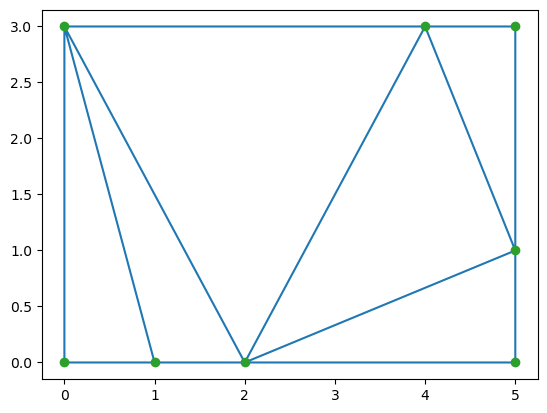

In [42]:
#Generation of points inside the rectangular for the ground floor: 
points1 = np.array([[0, 0], [0, 3], [5, 3], [5, 0], [5, 1], [4, 3], [2, 0], [1, 0]])
tri1 = Delaunay(points1)
tri1.simplices
points1[tri1.simplices]
plt.triplot(points1[:,0], points1[:,1], tri1.simplices)
plt.plot(points1[:,0], points1[:,1], 'o')
plt.show()

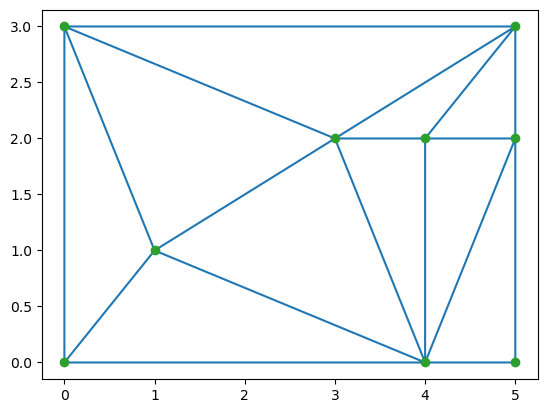

In [44]:
points2 = np.array([[0, 0], [0, 3], [5, 3], [5, 0], [3, 2], [4, 2], [1, 1], [5, 2], [4, 0]])
tri2 = Delaunay(points2)
tri2.simplices
points2[tri2.simplices]
plt.triplot(points2[:,0], points2[:,1], tri2.simplices)
plt.plot(points2[:,0], points2[:,1], 'o')
plt.show()

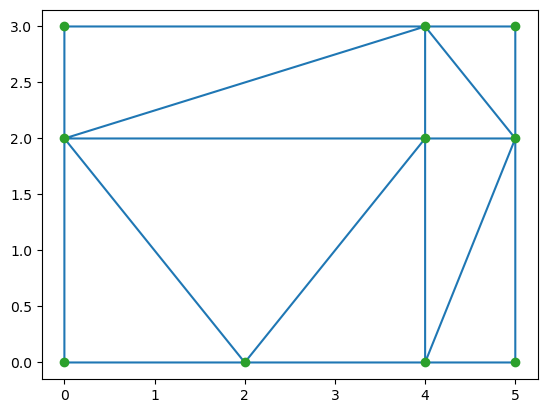

In [45]:
points3 = np.array([[0, 0], [0, 3], [5, 3], [5, 0], [2, 0], [0, 2], [4, 2], [4, 3], [5, 2], [4, 0]])
tri3 = Delaunay(points3)
tri3.simplices
points3[tri3.simplices]
plt.triplot(points3[:,0], points3[:,1], tri3.simplices)
plt.plot(points3[:,0], points3[:,1], 'o')
plt.show()

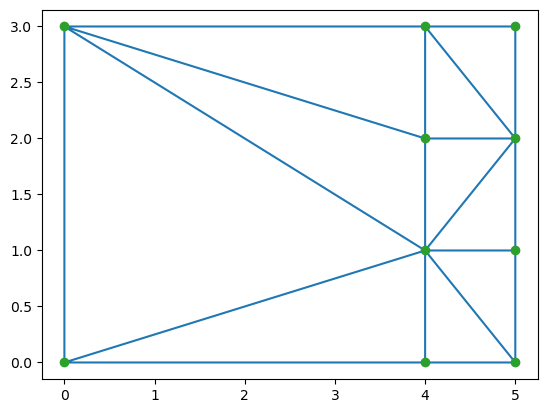

In [46]:
points4 = np.array([[0, 0], [0, 3], [5, 3], [5, 0], [5, 1], [5, 2], [4, 0], [4, 1], [4, 2], [4, 3]])
tri4 = Delaunay(points4)
tri4.simplices
points4[tri4.simplices]
plt.triplot(points4[:,0], points4[:,1], tri4.simplices)
plt.plot(points4[:,0], points4[:,1], 'o')
plt.show()

In [48]:
A = [points1[tri1.simplices], points2[tri2.simplices], points3[tri3.simplices], points4[tri4.simplices]]
B = []
#level
for l in range(len(A)): 
    #number of the cell
    for j in range(len(A[l])):
        B.append([x for y in [(A[l][j]).tolist(), [l], [0]] for x in y])

## Now we assign colors randomly to the cells we generated

In [50]:
B[0][4] = 8
B[1][4] = 0
B[2][4] = 0
B[3][4] = 9
B[4][4] = 9
B[5][4] = 9
B[6][4] = 0
B[7][4] = 5
B[8][4] = 4
B[9][4] = 5
B[10][4] = 3
B[11][4] = 4
B[12][4] = 0
B[13][4] = 0
B[14][4] = 7
B[15][4] = 7
B[16][4] = 0
B[17][4] = 0
B[18][4] = 1
B[19][4] = 0
B[20][4] = 0
B[21][4] = 6
B[22][4] = 6
B[23][4] = 7
B[24][4] = 7
B[25][4] = 0
B[26][4] = 2
B[27][4] = 6
B[28][4] = 6
B[29][4] = 0
B[30][4] = 0
B[31][4] = 7
B[32][4] = 7
B[33][4] = 7
B[34][4] = 7

B

[[[2, 0], [4, 3], [0, 3], 0, 8],
 [[1, 0], [0, 3], [0, 0], 0, 0],
 [[1, 0], [2, 0], [0, 3], 0, 0],
 [[5, 1], [2, 0], [5, 0], 0, 9],
 [[5, 1], [4, 3], [2, 0], 0, 9],
 [[4, 3], [5, 1], [5, 3], 0, 9],
 [[0, 3], [3, 2], [5, 3], 1, 0],
 [[3, 2], [4, 2], [5, 3], 1, 5],
 [[4, 0], [4, 2], [3, 2], 1, 4],
 [[4, 2], [5, 2], [5, 3], 1, 5],
 [[4, 0], [1, 1], [0, 0], 1, 3],
 [[1, 1], [4, 0], [3, 2], 1, 4],
 [[1, 1], [0, 3], [0, 0], 1, 0],
 [[1, 1], [3, 2], [0, 3], 1, 0],
 [[4, 0], [5, 2], [4, 2], 1, 7],
 [[5, 2], [4, 0], [5, 0], 1, 7],
 [[0, 2], [2, 0], [4, 2], 2, 0],
 [[2, 0], [0, 2], [0, 0], 2, 0],
 [[2, 0], [4, 0], [4, 2], 2, 1],
 [[4, 3], [0, 2], [4, 2], 2, 0],
 [[0, 2], [4, 3], [0, 3], 2, 0],
 [[5, 2], [4, 3], [4, 2], 2, 6],
 [[4, 3], [5, 2], [5, 3], 2, 6],
 [[4, 0], [5, 2], [4, 2], 2, 7],
 [[5, 2], [4, 0], [5, 0], 2, 7],
 [[4, 2], [4, 3], [0, 3], 3, 0],
 [[4, 0], [4, 1], [0, 0], 3, 2],
 [[5, 2], [4, 3], [4, 2], 3, 6],
 [[4, 3], [5, 2], [5, 3], 3, 6],
 [[4, 1], [4, 2], [0, 3], 3, 0],
 [[4, 1], 

## Heights were generated in the following way:

In [54]:
heights = defaultdict()
heights[0] = random.randint(1, 4)
heights[1] = random.randint(1, 4)
heights[2] = random.randint(1, 4)
heights[3] = random.randint(1, 4)

## As the result we obtained 30 buildings

In [55]:
buildings = [[[[0, 0], [0, 3], [2, 3], 0, 9], #building[0]
  [[0, 0], [3, 3], [2, 3], 0, 9],
  [[0, 0], [4, 2], [3, 3], 0, 0],
  [[0, 0], [4, 0], [4, 2], 0, 2],
  [[4, 0], [5, 0], [5, 1], 0, 5],
  [[4, 0], [5, 1], [4, 2], 0, 5],
  [[5, 1], [4, 2], [5, 3], 0, 5],
  [[4, 2], [3, 3], [5, 3], 0, 0],
  [[0, 0], [0, 1], [4, 2], 1, 0],
  [[0, 1], [0, 2], [4, 2], 1, 3],
  [[0, 2], [0, 3], [4, 2], 1, 3],
  [[4, 2], [0, 3], [5, 3], 1, 3],
  [[0, 0], [3, 0], [4, 2], 1, 2],
  [[3, 0], [4, 0], [4, 2], 1, 2],
  [[4, 0], [4, 2], [5, 3], 1, 5],
  [[4, 0], [5, 0], [5, 3], 1, 5],
  [[0, 0], [4, 2], [0, 3], 2, 1],
  [[0, 0], [4, 0], [4, 2], 2, 2],
  [[4, 2], [0, 3], [5, 3], 2, 0],
  [[4, 0], [5, 0], [4, 2], 2, 6],
  [[4, 2], [5, 3], [5, 0], 2, 6],
  [[0, 0], [0, 1], [2, 0], 3, 8],
  [[0, 1], [2, 0], [2, 1], 3, 8],
  [[0, 1], [2, 1], [2, 3], 3, 7],
  [[0, 1], [0, 3], [2, 3], 3, 7],
  [[2, 0], [2, 1], [5, 3], 3, 0],
  [[2, 1], [5, 3], [2, 3], 3, 0],
  [[2, 0], [5, 0], [5, 3], 3, 4]],
 [[[0, 0], [3, 3], [0, 3], 0, 9], #building[1]
  [[0, 0], [5, 3], [4, 0], 0, 2],
  [[4, 0], [5, 0], [5, 3], 0, 2],
  [[0, 0], [3, 3], [5, 3], 0, 1],
  [[0, 0], [0, 3], [1, 3], 1, 3],
  [[1, 0], [0, 0], [1, 3], 1, 3],
  [[1, 0], [1, 3], [2, 3], 1, 3],
  [[1, 0], [2, 0], [2, 3], 1, 4],
  [[2, 0], [5, 0], [2, 3], 1, 4],
  [[2, 3], [5, 3], [5, 0], 1, 0],
  [[0, 0], [1, 0], [0, 3], 2, 3],
  [[1, 0], [0, 3], [2, 3], 2, 3],
  [[1, 0], [2, 0], [2, 3], 2, 5],
  [[2, 0], [5, 0], [2, 3], 2, 0],
  [[5, 0], [2, 3], [5, 3], 2, 0],
  [[0, 0], [1, 0], [0, 1], 3, 7],
  [[1, 0], [0, 1], [5, 1], 3, 7],
  [[5, 0], [1, 0], [5, 1], 3, 7],
  [[0, 1], [0, 2], [5, 2], 3, 8],
  [[0, 1], [5, 1], [5, 2], 3, 8],
  [[0, 2], [0, 3], [2, 3], 3, 6],
  [[0, 2], [5, 2], [2, 3], 3, 6],
  [[2, 3], [5, 2], [5, 3], 3, 6]],
 [[[4, 2], [5, 0], [5, 3], 0, 1],#building[2]
  [[4, 3], [4, 2], [5, 3], 0, 0],
  [[1, 2], [4, 3], [0, 3], 0, 0],
  [[4, 3], [1, 2], [4, 2], 0, 0],
  [[1, 2], [0, 2], [0, 0], 0, 7],
  [[0, 2], [1, 2], [0, 3], 0, 0],
  [[4, 2], [4, 0], [5, 0], 0, 3],
  [[1, 2], [4, 0], [4, 2], 0, 3],
  [[4, 0], [1, 2], [0, 0], 0, 7],
  [[5, 2], [4, 2], [5, 0], 1, 1],
  [[4, 2], [5, 2], [5, 3], 1, 1],
  [[1, 2], [0, 2], [0, 0], 1, 5],
  [[4, 2], [3, 0], [5, 0], 1, 8],
  [[1, 2], [3, 0], [4, 2], 1, 8],
  [[3, 0], [1, 2], [0, 0], 1, 8],
  [[1, 3], [1, 2], [4, 2], 1, 0],
  [[1, 3], [4, 2], [5, 3], 1, 0],
  [[1, 3], [0, 2], [1, 2], 1, 5],
  [[0, 2], [1, 3], [0, 3], 1, 5],
  [[5, 2], [3, 1], [5, 0], 2, 0],
  [[4, 3], [5, 2], [5, 3], 2, 0],
  [[5, 2], [4, 3], [3, 1], 2, 0],
  [[3, 0], [2, 1], [0, 0], 2, 4],
  [[3, 0], [3, 1], [2, 1], 2, 4],
  [[3, 1], [3, 0], [5, 0], 2, 4],
  [[2, 1], [1, 3], [0, 0], 2, 6],
  [[1, 3], [0, 3], [0, 0], 2, 6],
  [[4, 3], [1, 3], [2, 1], 2, 0],
  [[3, 1], [4, 3], [2, 1], 2, 0],
  [[2, 3], [2, 0], [3, 1], 3, 9],
  [[4, 0], [5, 2], [3, 1], 3, 9],
  [[5, 2], [4, 0], [5, 0], 3, 0],
  [[2, 0], [3, 0], [3, 1], 3, 9],
  [[3, 0], [4, 0], [3, 1], 3, 9],
  [[5, 2], [2, 3], [3, 1], 3, 9],
  [[2, 3], [5, 2], [5, 3], 3, 0],
  [[2, 0], [2, 3], [0, 3], 3, 2],
  [[2, 0], [0, 3], [0, 0], 3, 2]],
 [[[4, 2], [5, 0], [5, 3], 0, 4],#building[3]
  [[3, 3], [4, 2], [5, 3], 0, 0],
  [[4, 2], [3, 0], [5, 0], 0, 4],
  [[1, 1], [3, 3], [0, 3], 0, 2],
  [[1, 1], [0, 3], [0, 0], 0, 0],
  [[3, 0], [1, 1], [0, 0], 0, 1],
  [[1, 1], [3, 0], [4, 2], 0, 1],
  [[3, 3], [1, 1], [4, 2], 0, 2],
  [[5, 2], [4, 2], [5, 0], 1, 4],
  [[4, 2], [5, 2], [5, 3], 1, 4],
  [[1, 2], [0, 2], [0, 0], 1, 3],
  [[0, 2], [1, 2], [0, 3], 1, 0],
  [[4, 2], [3, 0], [5, 0], 1, 4],
  [[1, 2], [3, 0], [4, 2], 1, 3],
  [[3, 0], [1, 2], [0, 0], 1, 3],
  [[0, 3], [1, 2], [5, 3], 1, 0],
  [[1, 2], [4, 2], [5, 3], 1, 0],
  [[0, 3], [2, 2], [5, 3], 2, 0],
  [[0, 2], [2, 2], [0, 3], 2, 7],
  [[4, 2], [5, 0], [5, 3], 2, 4],
  [[2, 2], [4, 2], [5, 3], 2, 0],
  [[4, 2], [3, 0], [5, 0], 2, 4],
  [[2, 0], [3, 0], [2, 2], 2, 8],
  [[3, 0], [4, 2], [2, 2], 2, 8],
  [[0, 2], [1, 0], [2, 2], 2, 7],
  [[1, 0], [0, 2], [0, 0], 2, 7],
  [[1, 0], [2, 0], [2, 2], 2, 7],
  [[3, 2], [5, 0], [5, 3], 3, 5],
  [[2, 2], [0, 3], [0, 0], 3, 7],
  [[2, 0], [2, 2], [0, 0], 3, 7],
  [[3, 2], [3, 0], [5, 0], 3, 5],
  [[0, 3], [2, 2], [5, 3], 3, 0],
  [[2, 2], [3, 2], [5, 3], 3, 0],
  [[2, 2], [3, 0], [3, 2], 3, 9],
  [[2, 0], [3, 0], [2, 2], 3, 6]],
 [[[4, 3], [5, 0], [5, 3], 0, 2],#building[4]
  [[4, 3], [3, 0], [5, 0], 0, 2],
  [[1, 2], [0, 3], [0, 0], 0, 3],
  [[3, 0], [1, 2], [0, 0], 0, 3],
  [[1, 2], [4, 3], [0, 3], 0, 3],
  [[4, 3], [1, 2], [3, 0], 0, 3],
  [[0, 2], [4, 3], [0, 3], 1, 3],
  [[4, 3], [0, 2], [3, 0], 1, 3],
  [[5, 2], [3, 0], [5, 0], 1, 9],
  [[5, 2], [4, 3], [3, 0], 1, 9],
  [[4, 3], [5, 2], [5, 3], 1, 0],
  [[1, 0], [0, 2], [0, 0], 1, 3],
  [[0, 2], [1, 0], [3, 0], 1, 3],
  [[3, 3], [5, 0], [5, 3], 2, 6],
  [[3, 3], [2, 2], [5, 0], 2, 6],
  [[3, 3], [1, 3], [2, 2], 2, 0],
  [[2, 0], [2, 2], [0, 0], 2, 5],
  [[2, 2], [2, 0], [5, 0], 2, 5],
  [[2, 2], [1, 3], [0, 0], 2, 4],
  [[1, 3], [0, 3], [0, 0], 2, 7],
  [[1, 3], [4, 2], [5, 3], 3, 0],
  [[4, 1], [1, 0], [5, 0], 3, 8],
  [[1, 0], [1, 3], [0, 3], 3, 1],
  [[1, 0], [0, 3], [0, 0], 3, 1],
  [[4, 2], [4, 1], [5, 3], 3, 0],
  [[4, 1], [5, 0], [5, 3], 3, 0],
  [[1, 0], [4, 1], [1, 3], 3, 1],
  [[1, 3], [4, 1], [4, 2], 3, 0]],
 [[[0, 3], [3, 2], [5, 3], 0, 0],#building[5]
  [[0, 2], [3, 2], [0, 3], 0, 8],
  [[5, 0], [4, 1], [0, 0], 0, 2],
  [[4, 1], [3, 2], [0, 0], 0, 2],
  [[4, 1], [5, 0], [5, 3], 0, 0],
  [[3, 2], [4, 1], [5, 3], 0, 0],
  [[3, 2], [0, 1], [0, 0], 0, 8],
  [[0, 2], [0, 1], [3, 2], 0, 8],
  [[1, 2], [0, 3], [0, 0], 1, 0],
  [[0, 3], [1, 2], [5, 3], 1, 0],
  [[1, 2], [4, 1], [5, 3], 1, 0],
  [[4, 0], [1, 2], [0, 0], 1, 6],
  [[1, 2], [4, 0], [4, 1], 1, 6],
  [[5, 1], [5, 2], [4, 1], 1, 5],
  [[4, 1], [5, 2], [5, 3], 1, 5],
  [[4, 0], [5, 1], [4, 1], 1, 5],
  [[5, 1], [4, 0], [5, 0], 1, 5],
  [[4, 2], [5, 0], [5, 3], 2, 4],
  [[2, 3], [4, 2], [5, 3], 2, 0],
  [[4, 2], [4, 0], [5, 0], 2, 1],
  [[0, 2], [2, 3], [0, 3], 2, 0],
  [[2, 3], [1, 0], [4, 2], 2, 3],
  [[1, 0], [4, 0], [4, 2], 2, 1],
  [[1, 0], [0, 1], [0, 0], 2, 9],
  [[0, 1], [1, 0], [0, 2], 2, 9],
  [[0, 2], [1, 0], [2, 3], 2, 3],
  [[0, 3], [4, 2], [5, 3], 3, 0],
  [[4, 2], [5, 0], [5, 3], 3, 4],
  [[4, 2], [1, 0], [5, 0], 3, 1],
  [[1, 1], [1, 0], [4, 2], 3, 7],
  [[1, 1], [4, 2], [0, 3], 3, 0],
  [[0, 1], [1, 1], [0, 3], 3, 0],
  [[1, 0], [1, 1], [0, 0], 3, 7],
  [[1, 1], [0, 1], [0, 0], 3, 0]],
 [[[1, 3], [5, 2], [5, 3], 0, 6],#building[6]
  [[5, 2], [1, 3], [5, 0], 0, 6],
  [[5, 0], [0, 1], [0, 0], 0, 1],
  [[1, 3], [0, 1], [5, 0], 0, 1],
  [[0, 1], [1, 3], [0, 3], 0, 0],
  [[5, 2], [1, 3], [4, 0], 1, 2],
  [[1, 3], [5, 2], [5, 3], 1, 2],
  [[5, 1], [4, 0], [5, 0], 1, 4],
  [[5, 1], [5, 2], [4, 0], 1, 4],
  [[4, 0], [0, 1], [0, 0], 1, 2],
  [[1, 3], [0, 1], [4, 0], 1, 2],
  [[0, 1], [1, 3], [0, 3], 1, 0],
  [[1, 3], [4, 2], [5, 3], 2, 0],
  [[4, 2], [5, 2], [5, 3], 2, 5],
  [[0, 1], [1, 3], [0, 3], 2, 0],
  [[5, 2], [4, 1], [5, 0], 2, 5],
  [[4, 1], [5, 2], [4, 2], 2, 5],
  [[4, 1], [4, 0], [5, 0], 2, 5],
  [[1, 3], [4, 1], [4, 2], 2, 3],
  [[0, 1], [4, 1], [1, 3], 2, 3],
  [[4, 1], [0, 1], [0, 0], 2, 7],
  [[4, 0], [4, 1], [0, 0], 2, 7],
  [[0, 3], [4, 1], [5, 3], 3, 0],
  [[0, 2], [4, 1], [0, 3], 3, 0],
  [[4, 1], [5, 1], [5, 3], 3, 8],
  [[0, 2], [0, 1], [4, 1], 3, 0],
  [[4, 0], [5, 1], [4, 1], 3, 9],
  [[5, 1], [4, 0], [5, 0], 3, 9],
  [[0, 1], [4, 0], [4, 1], 3, 7],
  [[4, 0], [0, 1], [0, 0], 3, 7]],
 [[[5, 2], [2, 0], [5, 0], 0, 6],#building[7]
  [[5, 2], [2, 3], [2, 0], 0, 6],
  [[2, 3], [5, 2], [5, 3], 0, 0],
  [[1, 0], [1, 3], [0, 3], 0, 3],
  [[1, 0], [0, 3], [0, 0], 0, 3],
  [[1, 3], [1, 0], [2, 3], 0, 3],
  [[2, 3], [1, 0], [2, 0], 0, 3],
  [[2, 3], [4, 2], [5, 3], 1, 4],
  [[4, 1], [4, 0], [5, 0], 1, 1],
  [[4, 0], [4, 1], [2, 0], 1, 7],
  [[2, 0], [2, 3], [0, 3], 1, 3],
  [[2, 0], [0, 3], [0, 0], 1, 3],
  [[4, 2], [4, 1], [5, 3], 1, 1],
  [[4, 1], [5, 0], [5, 3], 1, 1],
  [[2, 0], [4, 1], [2, 3], 1, 7],
  [[2, 3], [4, 1], [4, 2], 1, 7],
  [[0, 3], [4, 2], [5, 3], 2, 9],
  [[4, 1], [4, 0], [5, 0], 2, 1],
  [[4, 0], [4, 1], [0, 0], 2, 2],
  [[4, 2], [4, 1], [5, 3], 2, 1],
  [[4, 1], [5, 0], [5, 3], 2, 1],
  [[4, 1], [0, 3], [0, 0], 2, 5],
  [[4, 1], [4, 2], [0, 3], 2, 5],
  [[3, 3], [0, 3], [0, 0], 3, 8],
  [[3, 3], [4, 2], [5, 3], 3, 0],
  [[4, 1], [4, 0], [5, 0], 3, 1],
  [[3, 3], [4, 1], [4, 2], 3, 8],
  [[4, 1], [3, 3], [0, 0], 3, 8],
  [[4, 0], [4, 1], [0, 0], 3, 8],
  [[4, 2], [4, 1], [5, 3], 3, 1],
  [[4, 1], [5, 0], [5, 3], 3, 1]],
 [[[3, 3], [0, 3], [0, 0], 0, 5],#building[8]
  [[4, 0], [3, 3], [0, 0], 0, 5],
  [[4, 0], [4, 3], [3, 3], 0, 2],
  [[4, 3], [4, 0], [5, 3], 0, 2],
  [[4, 0], [5, 0], [5, 3], 0, 8],
  [[1, 3], [0, 3], [0, 0], 1, 4],
  [[4, 3], [1, 3], [3, 2], 1, 0],
  [[2, 0], [1, 3], [0, 0], 1, 4],
  [[1, 3], [2, 0], [3, 2], 1, 4],
  [[4, 1], [2, 0], [5, 0], 1, 3],
  [[2, 0], [4, 1], [3, 2], 1, 4],
  [[4, 1], [5, 0], [5, 3], 1, 0],
  [[4, 1], [4, 3], [3, 2], 1, 0],
  [[4, 3], [4, 1], [5, 3], 1, 0],
  [[1, 3], [0, 3], [0, 0], 2, 9],
  [[2, 0], [1, 3], [0, 0], 2, 9],
  [[5, 1], [2, 0], [5, 0], 2, 1],
  [[5, 1], [1, 3], [2, 0], 2, 1],
  [[1, 3], [5, 1], [5, 3], 2, 0],
  [[1, 2], [0, 3], [0, 0], 3, 7],
  [[4, 2], [5, 0], [5, 3], 3, 0],
  [[3, 2], [4, 2], [5, 3], 3, 0],
  [[4, 2], [3, 2], [5, 0], 3, 0],
  [[1, 2], [2, 2], [0, 3], 3, 7],
  [[2, 2], [1, 2], [0, 0], 3, 7],
  [[2, 2], [3, 2], [5, 3], 3, 0],
  [[0, 3], [2, 2], [5, 3], 3, 0],
  [[5, 0], [2, 2], [0, 0], 3, 6],
  [[3, 2], [2, 2], [5, 0], 3, 0]],
 [[[3, 3], [5, 0], [5, 3], 0, 9],#building[9]
  [[3, 3], [2, 2], [5, 0], 0, 9],
  [[2, 2], [3, 3], [0, 3], 0, 8],
  [[5, 0], [1, 1], [0, 0], 0, 9],
  [[2, 2], [1, 1], [5, 0], 0, 9],
  [[1, 1], [0, 3], [0, 0], 0, 7],
  [[1, 1], [2, 2], [0, 3], 0, 8],
  [[0, 3], [4, 2], [5, 3], 1, 2],
  [[4, 2], [5, 1], [5, 3], 1, 3],
  [[5, 1], [4, 2], [5, 0], 1, 3],
  [[5, 0], [1, 1], [0, 0], 1, 6],
  [[4, 2], [1, 1], [5, 0], 1, 6],
  [[1, 1], [0, 3], [0, 0], 1, 0],
  [[1, 1], [4, 2], [0, 3], 1, 2],
  [[0, 3], [4, 2], [5, 3], 2, 2],
  [[4, 2], [5, 0], [5, 3], 2, 3],
  [[5, 0], [1, 1], [0, 0], 2, 6],
  [[4, 2], [1, 1], [5, 0], 2, 6],
  [[1, 1], [0, 3], [0, 0], 2, 0],
  [[1, 1], [4, 2], [0, 3], 2, 2],
  [[2, 2], [0, 3], [0, 0], 3, 0],
  [[4, 2], [3, 2], [5, 0], 3, 5],
  [[3, 2], [4, 2], [5, 3], 3, 4],
  [[4, 2], [5, 2], [5, 3], 3, 4],
  [[5, 2], [4, 2], [5, 0], 3, 5],
  [[3, 2], [2, 2], [5, 0], 3, 5],
  [[5, 0], [2, 2], [0, 0], 3, 1],
  [[0, 3], [2, 2], [5, 3], 3, 4],
  [[2, 2], [3, 2], [5, 3], 3, 4]],
 [[[3, 3], [0, 2], [3, 2], 0, 8],#building[10]
  [[0, 2], [3, 3], [0, 3], 0, 5],
  [[0, 2], [3, 0], [3, 2], 0, 7],
  [[3, 0], [0, 2], [0, 0], 0, 0],
  [[4, 3], [5, 2], [5, 3], 0, 0],
  [[5, 2], [4, 3], [4, 2], 0, 2],
  [[4, 3], [3, 3], [3, 2], 0, 8],
  [[4, 2], [4, 3], [3, 2], 0, 2],
  [[4, 0], [5, 2], [4, 2], 0, 2],
  [[5, 2], [4, 0], [5, 0], 0, 0],
  [[3, 0], [4, 0], [3, 2], 0, 7],
  [[4, 0], [4, 2], [3, 2], 0, 2],
  [[0, 3], [3, 2], [5, 3], 1, 0],
  [[0, 2], [3, 2], [0, 3], 1, 3],
  [[3, 2], [4, 2], [5, 3], 1, 0],
  [[3, 0], [4, 2], [3, 2], 1, 9],
  [[4, 2], [5, 2], [5, 3], 1, 0],
  [[5, 1], [5, 2], [4, 2], 1, 0],
  [[5, 1], [3, 0], [5, 0], 1, 0],
  [[3, 0], [5, 1], [4, 2], 1, 9],
  [[0, 2], [3, 0], [3, 2], 1, 3],
  [[3, 0], [0, 2], [0, 0], 1, 0],
  [[0, 3], [3, 2], [5, 3], 2, 0],
  [[1, 2], [3, 2], [0, 3], 2, 0],
  [[3, 2], [4, 2], [5, 3], 2, 0],
  [[5, 0], [3, 1], [0, 0], 2, 0],
  [[3, 1], [1, 2], [0, 0], 2, 0],
  [[1, 2], [3, 1], [3, 2], 2, 1],
  [[1, 2], [0, 2], [0, 0], 2, 0],
  [[0, 2], [1, 2], [0, 3], 2, 0],
  [[4, 1], [3, 1], [5, 0], 2, 0],
  [[4, 2], [4, 1], [5, 3], 2, 0],
  [[4, 1], [5, 0], [5, 3], 2, 0],
  [[4, 1], [4, 2], [3, 2], 2, 6],
  [[3, 1], [4, 1], [3, 2], 2, 6],
  [[3, 2], [5, 0], [5, 3], 3, 0],
  [[2, 2], [0, 3], [0, 0], 3, 0],
  [[3, 2], [2, 2], [5, 0], 3, 0],
  [[5, 0], [2, 2], [0, 0], 3, 0],
  [[0, 3], [2, 2], [5, 3], 3, 4],
  [[2, 2], [3, 2], [5, 3], 3, 4]],
 [[[2, 3], [0, 3], [0, 0], 0, 7],#building[11]
  [[3, 0], [2, 3], [0, 0], 0, 7],
  [[5, 1], [4, 1], [5, 0], 0, 1],
  [[4, 1], [3, 0], [5, 0], 0, 1],
  [[3, 0], [4, 1], [2, 3], 0, 3],
  [[2, 3], [4, 1], [5, 3], 0, 8],
  [[4, 1], [5, 1], [5, 3], 0, 8],
  [[4, 1], [5, 0], [5, 3], 1, 0],
  [[1, 2], [0, 3], [0, 0], 1, 7],
  [[4, 1], [3, 0], [5, 0], 1, 0],
  [[2, 3], [4, 1], [5, 3], 1, 4],
  [[1, 2], [2, 3], [0, 3], 1, 7],
  [[1, 0], [3, 0], [1, 2], 1, 7],
  [[1, 0], [1, 2], [0, 0], 1, 7],
  [[3, 0], [2, 3], [1, 2], 1, 7],
  [[2, 3], [3, 0], [4, 1], 1, 4],
  [[4, 2], [5, 0], [5, 3], 2, 0],
  [[1, 2], [0, 3], [0, 0], 2, 7],
  [[4, 2], [3, 0], [5, 0], 2, 0],
  [[3, 0], [1, 2], [0, 0], 2, 7],
  [[2, 3], [4, 2], [5, 3], 2, 6],
  [[1, 2], [2, 3], [0, 3], 2, 7],
  [[3, 0], [2, 3], [1, 2], 2, 7],
  [[2, 3], [3, 0], [4, 2], 2, 2],
  [[2, 3], [4, 2], [5, 3], 3, 9],
  [[4, 2], [5, 1], [5, 3], 3, 0],
  [[3, 0], [5, 1], [4, 2], 3, 5],
  [[5, 1], [3, 0], [5, 0], 3, 5],
  [[0, 2], [2, 3], [0, 3], 3, 7],
  [[0, 2], [2, 0], [2, 3], 3, 7],
  [[2, 0], [0, 2], [0, 0], 3, 7],
  [[2, 0], [3, 0], [2, 3], 3, 7],
  [[2, 3], [3, 0], [4, 2], 3, 2]],
 [[[0, 3], [3, 2], [5, 3], 0, 0],#building[12]
  [[3, 2], [4, 2], [5, 3], 0, 0],
  [[5, 0], [3, 1], [0, 0], 0, 0],
  [[4, 1], [3, 1], [5, 0], 0, 0],
  [[3, 1], [3, 2], [0, 3], 0, 0],
  [[3, 1], [0, 3], [0, 0], 0, 0],
  [[4, 2], [4, 1], [5, 3], 0, 0],
  [[4, 1], [5, 0], [5, 3], 0, 0],
  [[3, 1], [4, 1], [3, 2], 0, 4],
  [[4, 1], [4, 2], [3, 2], 0, 4],
  [[2, 3], [5, 1], [5, 3], 1, 0],
  [[0, 2], [1, 3], [0, 3], 1, 0],
  [[1, 3], [0, 2], [2, 3], 1, 1],
  [[3, 0], [5, 1], [2, 3], 1, 8],
  [[5, 1], [3, 0], [5, 0], 1, 0],
  [[3, 0], [0, 2], [0, 0], 1, 0],
  [[0, 2], [3, 0], [2, 3], 1, 1],
  [[0, 2], [4, 3], [0, 3], 2, 0],
  [[4, 3], [5, 2], [5, 3], 2, 0],
  [[0, 2], [1, 0], [4, 3], 2, 2],
  [[1, 0], [0, 1], [0, 0], 2, 0],
  [[0, 1], [1, 0], [0, 2], 2, 6],
  [[1, 0], [5, 2], [4, 3], 2, 2],
  [[5, 2], [1, 0], [5, 0], 2, 0],
  [[4, 1], [2, 3], [0, 0], 3, 7],
  [[4, 1], [5, 1], [5, 3], 3, 5],
  [[4, 0], [4, 1], [0, 0], 3, 9],
  [[2, 3], [0, 2], [0, 0], 3, 3],
  [[3, 3], [4, 1], [5, 3], 3, 7],
  [[3, 3], [2, 3], [4, 1], 3, 7],
  [[0, 2], [1, 3], [0, 3], 3, 0],
  [[1, 3], [0, 2], [2, 3], 3, 3],
  [[4, 0], [5, 1], [4, 1], 3, 5],
  [[5, 1], [4, 0], [5, 0], 3, 0]],
 [[[0, 3], [3, 1], [5, 3], 0, 5],#building[13]
  [[5, 0], [3, 1], [0, 0], 0, 3],
  [[0, 2], [3, 1], [0, 3], 0, 1],
  [[4, 1], [5, 0], [5, 3], 0, 0],
  [[3, 1], [4, 1], [5, 3], 0, 0],
  [[4, 1], [3, 1], [5, 0], 0, 3],
  [[3, 1], [0, 1], [0, 0], 0, 1],
  [[0, 2], [0, 1], [3, 1], 0, 1],
  [[5, 0], [3, 2], [0, 0], 1, 0],
  [[3, 2], [0, 2], [0, 0], 1, 6],
  [[4, 2], [5, 0], [5, 3], 1, 0],
  [[3, 2], [4, 2], [5, 3], 1, 0],
  [[4, 2], [3, 2], [5, 0], 1, 0],
  [[0, 2], [1, 3], [0, 3], 1, 6],
  [[1, 3], [0, 2], [3, 2], 1, 6],
  [[1, 3], [3, 2], [5, 3], 1, 9],
  [[4, 1], [5, 0], [5, 3], 2, 0],
  [[4, 3], [4, 1], [5, 3], 2, 0],
  [[4, 3], [2, 3], [4, 1], 2, 0],
  [[4, 1], [1, 0], [5, 0], 2, 2],
  [[2, 3], [1, 0], [4, 1], 2, 2],
  [[0, 1], [2, 3], [0, 3], 2, 7],
  [[0, 1], [1, 0], [2, 3], 2, 7],
  [[1, 0], [0, 1], [0, 0], 2, 0],
  [[2, 3], [0, 3], [0, 0], 3, 4],
  [[3, 1], [2, 3], [0, 0], 3, 8],
  [[2, 3], [3, 1], [5, 3], 3, 0],
  [[3, 1], [5, 1], [5, 3], 3, 0],
  [[4, 0], [3, 1], [0, 0], 3, 0],
  [[5, 1], [4, 0], [5, 0], 3, 0],
  [[4, 0], [5, 1], [3, 1], 3, 0]],
 [[[0, 3], [2, 2], [5, 3], 0, 0],#building[14]
  [[2, 2], [4, 2], [5, 3], 0, 2],
  [[5, 0], [3, 1], [0, 0], 0, 5],
  [[3, 1], [4, 2], [2, 2], 0, 2],
  [[4, 2], [5, 1], [5, 3], 0, 6],
  [[5, 1], [3, 1], [5, 0], 0, 6],
  [[3, 1], [5, 1], [4, 2], 0, 6],
  [[3, 1], [1, 1], [0, 0], 0, 5],
  [[1, 1], [3, 1], [2, 2], 0, 8],
  [[1, 1], [0, 3], [0, 0], 0, 0],
  [[1, 1], [2, 2], [0, 3], 0, 8],
  [[0, 3], [4, 2], [5, 3], 1, 0],
  [[4, 2], [5, 0], [5, 3], 1, 1],
  [[5, 0], [4, 2], [0, 0], 1, 9],
  [[4, 2], [0, 1], [0, 0], 1, 9],
  [[0, 1], [4, 2], [0, 3], 1, 0],
  [[2, 2], [0, 3], [0, 0], 2, 0],
  [[3, 2], [5, 1], [5, 3], 2, 4],
  [[2, 2], [4, 0], [3, 2], 2, 7],
  [[4, 0], [2, 2], [0, 0], 2, 7],
  [[5, 1], [4, 0], [5, 0], 2, 0],
  [[4, 0], [5, 1], [3, 2], 2, 4],
  [[0, 3], [2, 2], [5, 3], 2, 0],
  [[2, 2], [3, 2], [5, 3], 2, 0],
  [[0, 3], [3, 0], [5, 3], 3, 3],
  [[3, 0], [0, 3], [0, 0], 3, 3],
  [[4, 0], [5, 0], [5, 3], 3, 0],
  [[3, 0], [4, 0], [5, 3], 3, 3]],
 [[[1, 3], [4, 1], [5, 3], 0, 1],#building[15]
  [[4, 1], [5, 1], [5, 3], 0, 3],
  [[5, 1], [4, 1], [5, 0], 0, 3],
  [[4, 1], [1, 0], [5, 0], 0, 0],
  [[1, 3], [1, 0], [4, 1], 0, 1],
  [[1, 0], [1, 3], [0, 3], 0, 0],
  [[1, 0], [0, 3], [0, 0], 0, 0],
  [[3, 3], [5, 1], [5, 3], 1, 9],
  [[0, 2], [2, 3], [0, 3], 1, 0],
  [[2, 3], [0, 2], [0, 0], 1, 5],
  [[5, 1], [4, 0], [5, 0], 1, 0],
  [[4, 0], [5, 1], [3, 3], 1, 5],
  [[4, 0], [2, 3], [0, 0], 1, 5],
  [[2, 3], [4, 0], [3, 3], 1, 5],
  [[2, 0], [0, 3], [0, 0], 2, 0],
  [[4, 0], [5, 0], [5, 3], 2, 0],
  [[3, 0], [4, 0], [5, 3], 2, 2],
  [[0, 3], [3, 0], [5, 3], 2, 2],
  [[2, 0], [3, 0], [0, 3], 2, 8],
  [[3, 2], [5, 0], [5, 3], 3, 0],
  [[5, 0], [1, 1], [0, 0], 3, 0],
  [[3, 2], [1, 1], [5, 0], 3, 6],
  [[1, 2], [1, 1], [3, 2], 3, 6],
  [[1, 2], [1, 3], [0, 3], 3, 4],
  [[1, 3], [1, 2], [3, 2], 3, 6],
  [[1, 3], [3, 2], [5, 3], 3, 0],
  [[0, 1], [1, 2], [0, 3], 3, 4],
  [[0, 1], [1, 1], [1, 2], 3, 7],
  [[1, 1], [0, 1], [0, 0], 3, 7]],
 [[[2, 3], [2, 2], [5, 3], 0, 9],#building[16]
  [[2, 2], [2, 3], [0, 3], 0, 4],
  [[2, 1], [2, 0], [5, 0], 0, 0],
  [[2, 0], [2, 1], [0, 0], 0, 0],
  [[2, 2], [2, 1], [5, 3], 0, 9],
  [[2, 1], [5, 0], [5, 3], 0, 9],
  [[2, 1], [0, 3], [0, 0], 0, 4],
  [[2, 1], [2, 2], [0, 3], 0, 4],
  [[0, 3], [3, 2], [5, 3], 1, 0],
  [[3, 2], [0, 3], [0, 0], 1, 0],
  [[3, 2], [4, 2], [5, 3], 1, 0],
  [[3, 0], [3, 2], [0, 0], 1, 3],
  [[3, 0], [4, 2], [3, 2], 1, 7],
  [[4, 2], [5, 2], [5, 3], 1, 0],
  [[5, 1], [5, 2], [4, 2], 1, 7],
  [[5, 1], [3, 0], [5, 0], 1, 0],
  [[3, 0], [5, 1], [4, 2], 1, 7],
  [[3, 1], [2, 2], [0, 0], 2, 2],
  [[2, 3], [1, 3], [2, 2], 2, 0],
  [[4, 0], [3, 1], [0, 0], 2, 0],
  [[3, 1], [2, 3], [2, 2], 2, 5],
  [[2, 3], [3, 1], [5, 3], 2, 0],
  [[2, 2], [1, 3], [0, 0], 2, 2],
  [[1, 3], [0, 3], [0, 0], 2, 0],
  [[3, 1], [4, 0], [5, 3], 2, 1],
  [[4, 0], [5, 0], [5, 3], 2, 0],
  [[0, 3], [4, 2], [5, 3], 3, 8],
  [[4, 2], [5, 0], [5, 3], 3, 0],
  [[4, 2], [3, 0], [5, 0], 3, 0],
  [[1, 0], [4, 2], [0, 3], 3, 6],
  [[1, 0], [3, 0], [4, 2], 3, 6],
  [[1, 0], [0, 3], [0, 0], 3, 0]],
 [[[2, 1], [0, 1], [0, 0], 0, 6],#building[17]
  [[4, 0], [2, 1], [0, 0], 0, 6],
  [[4, 0], [5, 0], [5, 3], 0, 0],
  [[2, 2], [2, 3], [0, 3], 0, 3],
  [[2, 2], [0, 1], [2, 1], 0, 0],
  [[0, 1], [2, 2], [0, 3], 0, 0],
  [[2, 3], [2, 2], [5, 3], 0, 2],
  [[2, 2], [4, 0], [5, 3], 0, 2],
  [[4, 0], [2, 2], [2, 1], 0, 2],
  [[0, 3], [3, 2], [5, 3], 1, 0],
  [[3, 2], [0, 3], [0, 0], 1, 5],
  [[3, 2], [4, 2], [5, 3], 1, 0],
  [[3, 0], [3, 2], [0, 0], 1, 5],
  [[3, 0], [4, 2], [3, 2], 1, 1],
  [[4, 2], [5, 2], [5, 3], 1, 0],
  [[5, 1], [5, 2], [4, 2], 1, 0],
  [[5, 1], [3, 0], [5, 0], 1, 0],
  [[3, 0], [5, 1], [4, 2], 1, 1],
  [[2, 3], [0, 3], [0, 0], 2, 9],
  [[2, 3], [3, 2], [5, 3], 2, 0],
  [[3, 1], [3, 0], [5, 0], 2, 0],
  [[3, 0], [3, 1], [0, 0], 2, 0],
  [[3, 1], [2, 3], [0, 0], 2, 9],
  [[2, 3], [3, 1], [3, 2], 2, 9],
  [[3, 2], [3, 1], [5, 3], 2, 7],
  [[3, 1], [5, 0], [5, 3], 2, 7],
  [[0, 3], [4, 2], [5, 3], 3, 8],
  [[4, 2], [5, 0], [5, 3], 3, 0],
  [[0, 1], [4, 2], [0, 3], 3, 8],
  [[4, 2], [4, 0], [5, 0], 3, 0],
  [[0, 1], [1, 0], [4, 2], 3, 4],
  [[1, 0], [4, 0], [4, 2], 3, 4],
  [[1, 0], [0, 1], [0, 0], 3, 0]],
 [[[0, 3], [3, 1], [5, 3], 0, 0],#building[18]
  [[3, 1], [5, 0], [5, 3], 0, 7],
  [[5, 0], [3, 1], [0, 0], 0, 1],
  [[3, 1], [0, 1], [0, 0], 0, 1],
  [[0, 1], [3, 1], [0, 3], 0, 0],
  [[4, 2], [0, 3], [0, 0], 1, 0],
  [[4, 2], [5, 0], [5, 3], 1, 5],
  [[5, 0], [4, 2], [0, 0], 1, 9],
  [[4, 3], [4, 2], [5, 3], 1, 5],
  [[4, 2], [4, 3], [0, 3], 1, 0],
  [[4, 3], [5, 0], [5, 3], 2, 6],
  [[3, 0], [4, 3], [3, 3], 2, 3],
  [[4, 3], [3, 0], [5, 0], 2, 3],
  [[3, 0], [3, 3], [0, 3], 2, 2],
  [[3, 0], [0, 3], [0, 0], 2, 2],
  [[0, 3], [4, 1], [5, 3], 3, 0],
  [[5, 0], [4, 1], [0, 0], 3, 0],
  [[4, 1], [0, 1], [0, 0], 3, 4],
  [[0, 1], [4, 1], [0, 3], 3, 0],
  [[4, 1], [5, 2], [5, 3], 3, 8],
  [[5, 2], [4, 1], [5, 0], 3, 0]],
 [[[0, 1], [3, 3], [0, 3], 0, 0],#building[19]
  [[0, 1], [4, 0], [3, 3], 0, 2],
  [[4, 0], [0, 1], [0, 0], 0, 0],
  [[4, 0], [5, 0], [5, 3], 0, 0],
  [[3, 3], [4, 0], [5, 3], 0, 4],
  [[0, 3], [2, 2], [5, 3], 1, 0],
  [[1, 2], [0, 3], [0, 0], 1, 0],
  [[1, 2], [2, 2], [0, 3], 1, 3],
  [[5, 0], [2, 1], [0, 0], 1, 0],
  [[2, 1], [1, 2], [0, 0], 1, 0],
  [[1, 2], [2, 1], [2, 2], 1, 3],
  [[2, 2], [2, 1], [5, 3], 1, 1],
  [[2, 1], [5, 0], [5, 3], 1, 1],
  [[0, 2], [3, 3], [0, 3], 2, 9],
  [[3, 0], [0, 2], [0, 0], 2, 0],
  [[0, 2], [3, 0], [3, 3], 2, 0],
  [[3, 3], [4, 0], [5, 3], 2, 8],
  [[4, 0], [5, 0], [5, 3], 2, 8],
  [[3, 0], [4, 0], [3, 3], 2, 0],
  [[0, 3], [3, 2], [5, 3], 3, 7],
  [[4, 2], [5, 0], [5, 3], 3, 5],
  [[3, 2], [4, 2], [5, 3], 3, 0],
  [[4, 2], [3, 2], [5, 0], 3, 0],
  [[5, 0], [1, 1], [0, 0], 3, 0],
  [[3, 2], [1, 1], [5, 0], 3, 0],
  [[1, 1], [0, 3], [0, 0], 3, 6],
  [[1, 1], [3, 2], [0, 3], 3, 0]],
 [[[0, 3], [2, 2], [5, 3], 0, 0],#building[20]
  [[2, 2], [0, 3], [0, 0], 0, 0],
  [[4, 2], [5, 0], [5, 3], 0, 5],
  [[2, 2], [4, 2], [5, 3], 0, 0],
  [[5, 0], [3, 1], [0, 0], 0, 1],
  [[3, 1], [2, 2], [0, 0], 0, 9],
  [[4, 2], [3, 1], [5, 0], 0, 5],
  [[3, 1], [4, 2], [2, 2], 0, 9],
  [[4, 1], [5, 0], [5, 3], 1, 7],
  [[4, 1], [2, 0], [5, 0], 1, 0],
  [[2, 0], [1, 1], [0, 0], 1, 2],
  [[1, 2], [4, 1], [5, 3], 1, 3],
  [[0, 3], [1, 2], [5, 3], 1, 0],
  [[1, 2], [1, 1], [2, 0], 1, 2],
  [[4, 1], [1, 2], [2, 0], 1, 3],
  [[1, 2], [0, 3], [0, 0], 1, 0],
  [[1, 1], [1, 2], [0, 0], 1, 2],
  [[2, 2], [0, 3], [0, 0], 2, 0],
  [[5, 0], [2, 2], [0, 0], 2, 4],
  [[3, 3], [5, 0], [5, 3], 2, 0],
  [[3, 3], [2, 2], [5, 0], 2, 4],
  [[2, 2], [3, 3], [0, 3], 2, 0],
  [[0, 3], [2, 2], [5, 3], 3, 0],
  [[2, 2], [0, 3], [0, 0], 3, 0],
  [[2, 2], [4, 2], [5, 3], 3, 0],
  [[3, 0], [2, 2], [0, 0], 3, 6],
  [[3, 0], [4, 2], [2, 2], 3, 6],
  [[5, 1], [3, 0], [5, 0], 3, 8],
  [[3, 0], [5, 1], [4, 2], 3, 8],
  [[4, 2], [5, 2], [5, 3], 3, 0],
  [[5, 1], [5, 2], [4, 2], 3, 8]],
 [[[4, 0], [4, 3], [2, 3], 0, 8],#building[21]
  [[4, 0], [1, 1], [0, 0], 0, 0],
  [[1, 1], [4, 0], [2, 3], 0, 8],
  [[1, 1], [2, 3], [0, 3], 0, 8],
  [[1, 1], [0, 3], [0, 0], 0, 0],
  [[4, 3], [4, 0], [5, 3], 0, 7],
  [[4, 0], [5, 0], [5, 3], 0, 7],
  [[0, 3], [4, 1], [5, 3], 1, 2],
  [[4, 1], [0, 3], [0, 0], 1, 5],
  [[5, 0], [4, 1], [0, 0], 1, 0],
  [[4, 1], [5, 2], [5, 3], 1, 2],
  [[5, 2], [4, 1], [5, 0], 1, 0],
  [[5, 0], [3, 2], [0, 0], 2, 9],
  [[1, 2], [0, 3], [0, 0], 2, 6],
  [[3, 2], [1, 2], [0, 0], 2, 6],
  [[5, 2], [3, 2], [5, 0], 2, 0],
  [[5, 2], [4, 3], [3, 2], 2, 0],
  [[4, 3], [5, 2], [5, 3], 2, 0],
  [[4, 3], [1, 2], [3, 2], 2, 6],
  [[1, 2], [4, 3], [0, 3], 2, 6],
  [[5, 0], [1, 2], [0, 0], 3, 0],
  [[1, 2], [2, 3], [0, 3], 3, 3],
  [[1, 2], [0, 3], [0, 0], 3, 0],
  [[5, 1], [4, 3], [2, 3], 3, 4],
  [[1, 2], [5, 1], [2, 3], 3, 1],
  [[5, 1], [1, 2], [5, 0], 3, 0],
  [[4, 3], [5, 1], [5, 3], 3, 4]],
 [[[0, 3], [4, 2], [5, 3], 0, 7],#building[22]
  [[4, 2], [5, 0], [5, 3], 0, 0],
  [[0, 2], [4, 2], [0, 3], 0, 7],
  [[4, 2], [1, 0], [5, 0], 0, 0],
  [[1, 0], [0, 2], [0, 0], 0, 0],
  [[0, 2], [1, 0], [4, 2], 0, 3],
  [[0, 3], [3, 2], [5, 3], 1, 7],
  [[0, 2], [3, 2], [0, 3], 1, 7],
  [[4, 2], [5, 0], [5, 3], 1, 0],
  [[3, 2], [4, 2], [5, 3], 1, 7],
  [[1, 0], [0, 2], [0, 0], 1, 0],
  [[0, 2], [1, 0], [3, 2], 1, 2],
  [[1, 0], [4, 0], [3, 2], 1, 0],
  [[4, 2], [4, 0], [5, 0], 1, 0],
  [[4, 0], [4, 2], [3, 2], 1, 5],
  [[3, 3], [5, 2], [5, 3], 2, 9],
  [[5, 2], [3, 3], [5, 0], 2, 9],
  [[5, 0], [1, 2], [0, 0], 2, 0],
  [[3, 3], [1, 2], [5, 0], 2, 9],
  [[1, 2], [0, 3], [0, 0], 2, 0],
  [[1, 2], [3, 3], [0, 3], 2, 9],
  [[2, 2], [3, 3], [0, 3], 3, 1],
  [[3, 0], [3, 3], [2, 2], 3, 6],
  [[1, 1], [0, 1], [0, 0], 3, 0],
  [[1, 1], [3, 0], [2, 2], 3, 6],
  [[3, 0], [1, 1], [0, 0], 3, 0],
  [[1, 1], [2, 2], [0, 3], 3, 1],
  [[0, 1], [1, 1], [0, 3], 3, 0],
  [[3, 3], [3, 0], [5, 3], 3, 8],
  [[3, 0], [5, 0], [5, 3], 3, 4]],
 [[[0, 3], [2, 2], [5, 3], 0, 0],#building[23]
  [[2, 2], [5, 0], [5, 3], 0, 4],
  [[0, 1], [2, 2], [0, 3], 0, 7],
  [[2, 2], [1, 0], [5, 0], 0, 4],
  [[1, 0], [0, 1], [0, 0], 0, 7],
  [[0, 1], [1, 0], [2, 2], 0, 7],
  [[4, 2], [5, 0], [5, 3], 1, 8],
  [[1, 2], [0, 3], [0, 0], 1, 8],
  [[3, 3], [1, 2], [4, 2], 1, 8],
  [[3, 3], [4, 2], [5, 3], 1, 8],
  [[1, 2], [3, 3], [0, 3], 1, 8],
  [[4, 2], [1, 2], [5, 0], 1, 8],
  [[5, 0], [1, 2], [0, 0], 1, 8],
  [[1, 1], [0, 3], [0, 0], 2, 5],
  [[1, 1], [2, 3], [0, 3], 2, 0],
  [[3, 0], [1, 1], [0, 0], 2, 6],
  [[3, 0], [2, 3], [1, 1], 2, 0],
  [[3, 0], [5, 0], [5, 3], 2, 2],
  [[2, 3], [3, 0], [5, 3], 2, 0],
  [[0, 3], [2, 2], [5, 3], 3, 0],
  [[2, 2], [5, 0], [5, 3], 3, 0],
  [[0, 2], [2, 2], [0, 3], 3, 3],
  [[2, 2], [2, 0], [5, 0], 3, 1],
  [[0, 2], [1, 1], [2, 2], 3, 9],
  [[1, 1], [2, 0], [2, 2], 3, 9],
  [[0, 1], [1, 1], [0, 2], 3, 9],
  [[1, 1], [1, 0], [2, 0], 3, 9],
  [[1, 0], [0, 1], [0, 0], 3, 9],
  [[0, 1], [1, 0], [1, 1], 3, 9]],
 [[[4, 0], [5, 0], [5, 3], 0, 0],#building[24]
  [[0, 3], [0, 2], [5, 3], 0, 0],
  [[0, 2], [4, 0], [5, 3], 0, 3],
  [[4, 0], [0, 1], [0, 0], 0, 0],
  [[0, 2], [0, 1], [4, 0], 0, 1],
  [[1, 1], [0, 3], [0, 0], 1, 8],
  [[2, 1], [1, 1], [0, 0], 1, 8],
  [[1, 1], [2, 1], [0, 3], 1, 8],
  [[3, 1], [5, 1], [5, 3], 1, 4],
  [[5, 1], [3, 1], [5, 0], 1, 4],
  [[2, 1], [3, 1], [0, 3], 1, 8],
  [[0, 3], [3, 1], [5, 3], 1, 4],
  [[5, 0], [3, 1], [0, 0], 1, 9],
  [[3, 1], [2, 1], [0, 0], 1, 8],
  [[0, 3], [2, 0], [5, 3], 2, 5],
  [[2, 0], [5, 0], [5, 3], 2, 0],
  [[1, 0], [0, 3], [0, 0], 2, 0],
  [[1, 0], [2, 0], [0, 3], 2, 5],
  [[0, 3], [2, 1], [5, 3], 3, 2],
  [[1, 1], [0, 3], [0, 0], 3, 0],
  [[1, 1], [2, 1], [0, 3], 3, 7],
  [[2, 0], [1, 1], [0, 0], 3, 0],
  [[1, 1], [2, 0], [2, 1], 3, 7],
  [[2, 0], [3, 0], [2, 1], 3, 6],
  [[3, 0], [5, 0], [5, 3], 3, 0],
  [[2, 1], [3, 0], [5, 3], 3, 2]],
 [[[0, 3], [3, 2], [5, 3], 0, 0],#building[25]
  [[5, 0], [3, 2], [0, 0], 0, 0],
  [[3, 2], [1, 2], [0, 0], 0, 4],
  [[1, 2], [3, 2], [0, 3], 0, 4],
  [[3, 2], [4, 2], [5, 3], 0, 5],
  [[4, 2], [3, 2], [5, 0], 0, 5],
  [[1, 2], [0, 2], [0, 0], 0, 4],
  [[0, 2], [1, 2], [0, 3], 0, 4],
  [[4, 2], [5, 2], [5, 3], 0, 5],
  [[5, 2], [4, 2], [5, 0], 0, 5],
  [[0, 3], [3, 1], [5, 3], 1, 7],
  [[3, 1], [5, 0], [5, 3], 1, 7],
  [[5, 0], [3, 1], [0, 0], 1, 2],
  [[3, 1], [1, 1], [0, 0], 1, 8],
  [[1, 1], [3, 1], [0, 3], 1, 8],
  [[1, 1], [0, 2], [0, 0], 1, 8],
  [[0, 2], [1, 1], [0, 3], 1, 8],
  [[5, 0], [2, 2], [0, 0], 2, 6],
  [[3, 3], [5, 0], [5, 3], 2, 0],
  [[3, 3], [2, 2], [5, 0], 2, 3],
  [[3, 3], [1, 3], [2, 2], 2, 1],
  [[2, 2], [1, 3], [0, 0], 2, 1],
  [[1, 3], [0, 3], [0, 0], 2, 0],
  [[0, 3], [2, 2], [5, 3], 3, 0],
  [[1, 0], [2, 0], [2, 2], 3, 9],
  [[4, 1], [2, 0], [5, 0], 3, 0],
  [[2, 0], [4, 1], [2, 2], 3, 9],
  [[4, 1], [5, 0], [5, 3], 3, 0],
  [[2, 2], [4, 1], [5, 3], 3, 0],
  [[1, 0], [2, 2], [0, 3], 3, 0],
  [[1, 0], [0, 3], [0, 0], 3, 0]],
 [[[3, 1], [5, 0], [5, 3], 0, 8],#building[26]
  [[5, 0], [3, 1], [0, 0], 0, 2],
  [[3, 3], [3, 1], [5, 3], 0, 8],
  [[1, 1], [0, 3], [0, 0], 0, 0],
  [[3, 1], [1, 1], [0, 0], 0, 2],
  [[1, 1], [3, 3], [0, 3], 0, 0],
  [[3, 3], [1, 1], [3, 1], 0, 0],
  [[5, 0], [2, 1], [0, 0], 1, 7],
  [[2, 1], [4, 3], [0, 3], 1, 0],
  [[4, 3], [5, 0], [5, 3], 1, 1],
  [[4, 3], [2, 1], [5, 0], 1, 1],
  [[2, 1], [0, 1], [0, 0], 1, 0],
  [[0, 1], [2, 1], [0, 3], 1, 0],
  [[1, 0], [0, 3], [0, 0], 2, 0],
  [[4, 0], [3, 3], [2, 0], 2, 9],
  [[4, 0], [5, 0], [5, 3], 2, 5],
  [[3, 3], [4, 0], [5, 3], 2, 5],
  [[1, 0], [3, 3], [0, 3], 2, 0],
  [[3, 3], [1, 0], [2, 0], 2, 9],
  [[0, 3], [2, 2], [5, 3], 3, 0],
  [[2, 2], [3, 1], [5, 3], 3, 4],
  [[1, 1], [3, 1], [2, 2], 3, 6],
  [[1, 1], [0, 3], [0, 0], 3, 0],
  [[1, 1], [2, 2], [0, 3], 3, 0],
  [[3, 1], [4, 0], [5, 3], 3, 4],
  [[4, 0], [5, 0], [5, 3], 3, 0],
  [[1, 1], [4, 0], [3, 1], 3, 3],
  [[4, 0], [1, 1], [0, 0], 3, 0]],
 [[[3, 1], [5, 0], [5, 3], 0, 5],#building[27]
  [[5, 0], [3, 1], [0, 0], 0, 0],
  [[3, 3], [3, 1], [5, 3], 0, 5],
  [[1, 1], [0, 3], [0, 0], 0, 9],
  [[3, 1], [1, 1], [0, 0], 0, 9],
  [[1, 1], [3, 3], [0, 3], 0, 9],
  [[3, 3], [1, 1], [3, 1], 0, 9],
  [[5, 0], [2, 1], [0, 0], 1, 0],
  [[2, 1], [4, 3], [0, 3], 1, 6],
  [[4, 3], [5, 0], [5, 3], 1, 2],
  [[4, 3], [2, 1], [5, 0], 1, 2],
  [[2, 1], [0, 1], [0, 0], 1, 0],
  [[0, 1], [2, 1], [0, 3], 1, 6],
  [[1, 0], [0, 3], [0, 0], 2, 8],
  [[4, 0], [3, 3], [2, 0], 2, 1],
  [[4, 0], [5, 0], [5, 3], 2, 1],
  [[3, 3], [4, 0], [5, 3], 2, 1],
  [[1, 0], [3, 3], [0, 3], 2, 8],
  [[3, 3], [1, 0], [2, 0], 2, 8],
  [[3, 3], [5, 0], [5, 3], 3, 3],
  [[0, 2], [3, 3], [0, 3], 3, 4],
  [[3, 3], [1, 0], [5, 0], 3, 3],
  [[0, 2], [1, 0], [3, 3], 3, 7],
  [[1, 0], [0, 1], [0, 0], 3, 7],
  [[0, 1], [1, 0], [0, 2], 3, 7]],
 [[[0, 1], [2, 3], [0, 3], 0, 0],#building[28]
  [[2, 3], [5, 1], [5, 3], 0, 8],
  [[5, 1], [0, 1], [0, 0], 0, 4],
  [[5, 0], [5, 1], [0, 0], 0, 4],
  [[0, 1], [5, 1], [2, 3], 0, 8],
  [[5, 2], [2, 2], [5, 0], 1, 2],
  [[5, 0], [1, 1], [0, 0], 1, 6],
  [[2, 2], [1, 1], [5, 0], 1, 2],
  [[1, 1], [0, 3], [0, 0], 1, 0],
  [[1, 1], [2, 2], [0, 3], 1, 0],
  [[4, 3], [5, 2], [5, 3], 1, 5],
  [[5, 2], [4, 3], [2, 2], 1, 5],
  [[2, 2], [4, 3], [0, 3], 1, 0],
  [[5, 0], [3, 1], [0, 0], 2, 9],
  [[0, 3], [4, 2], [5, 3], 2, 0],
  [[3, 1], [4, 2], [0, 3], 2, 0],
  [[3, 1], [0, 2], [0, 0], 2, 0],
  [[0, 2], [3, 1], [0, 3], 2, 0],
  [[4, 2], [5, 2], [5, 3], 2, 7],
  [[5, 1], [3, 1], [5, 0], 2, 3],
  [[5, 1], [4, 2], [3, 1], 2, 3],
  [[5, 1], [5, 2], [4, 2], 2, 7],
  [[0, 3], [4, 0], [5, 3], 3, 0],
  [[4, 0], [0, 3], [0, 0], 3, 0],
  [[4, 0], [5, 1], [5, 3], 3, 1],
  [[5, 1], [4, 0], [5, 0], 3, 1]],
 [[[2, 0], [4, 3], [0, 3], 0, 8],#building[29]
  [[1, 0], [0, 3], [0, 0], 0, 0],
  [[1, 0], [2, 0], [0, 3], 0, 0],
  [[5, 1], [2, 0], [5, 0], 0, 9],
  [[5, 1], [4, 3], [2, 0], 0, 9],
  [[4, 3], [5, 1], [5, 3], 0, 9],
  [[0, 3], [3, 2], [5, 3], 1, 0],
  [[3, 2], [4, 2], [5, 3], 1, 5],
  [[4, 0], [4, 2], [3, 2], 1, 4],
  [[4, 2], [5, 2], [5, 3], 1, 5],
  [[4, 0], [1, 1], [0, 0], 1, 3],
  [[1, 1], [4, 0], [3, 2], 1, 4],
  [[1, 1], [0, 3], [0, 0], 1, 0],
  [[1, 1], [3, 2], [0, 3], 1, 0],
  [[4, 0], [5, 2], [4, 2], 1, 7],
  [[5, 2], [4, 0], [5, 0], 1, 7],
  [[0, 2], [2, 0], [4, 2], 2, 0],
  [[2, 0], [0, 2], [0, 0], 2, 0],
  [[2, 0], [4, 0], [4, 2], 2, 1],
  [[4, 3], [0, 2], [4, 2], 2, 0],
  [[0, 2], [4, 3], [0, 3], 2, 0],
  [[5, 2], [4, 3], [4, 2], 2, 6],
  [[4, 3], [5, 2], [5, 3], 2, 6],
  [[4, 0], [5, 2], [4, 2], 2, 7],
  [[5, 2], [4, 0], [5, 0], 2, 7],
  [[4, 2], [4, 3], [0, 3], 3, 0],
  [[4, 0], [4, 1], [0, 0], 3, 2],
  [[5, 2], [4, 3], [4, 2], 3, 6],
  [[4, 3], [5, 2], [5, 3], 3, 6],
  [[4, 1], [4, 2], [0, 3], 3, 0],
  [[4, 1], [0, 3], [0, 0], 3, 0],
  [[4, 1], [5, 2], [4, 2], 3, 7],
  [[5, 2], [4, 1], [5, 1], 3, 7],
  [[5, 1], [4, 1], [5, 0], 3, 7],
  [[4, 1], [4, 0], [5, 0], 3, 7]]]

In [56]:
heightss = [defaultdict(None, {0: 4, 1: 3, 2: 1, 3: 4}),
 defaultdict(None, {0: 3, 1: 3, 2: 2, 3: 1}),
 defaultdict(None, {0: 2, 1: 3, 2: 1, 3: 2}),
 defaultdict(None, {0: 1, 1: 4, 2: 2, 3: 2}),
 defaultdict(None, {0: 1, 1: 4, 2: 3, 3: 3}),
 defaultdict(None, {0: 4, 1: 2, 2: 2, 3: 3}),
 defaultdict(None, {0: 1, 1: 2, 2: 2, 3: 1}),
 defaultdict(None, {0: 3, 1: 3, 2: 4, 3: 3}),
 defaultdict(None, {0: 2, 1: 2, 2: 3, 3: 4}),
 defaultdict(None, {0: 2, 1: 3, 2: 2, 3: 1}),
 defaultdict(None, {0: 3, 1: 3, 2: 4, 3: 3}),
 defaultdict(None, {0: 1, 1: 1, 2: 2, 3: 2}),
 defaultdict(None, {0: 3, 1: 3, 2: 3, 3: 1}),
 defaultdict(None, {0: 2, 1: 4, 2: 4, 3: 3}),
 defaultdict(None, {0: 1, 1: 3, 2: 1, 3: 4}),
 defaultdict(None, {0: 3, 1: 4, 2: 2, 3: 1}),
 defaultdict(None, {0: 2, 1: 2, 2: 3, 3: 2}),
 defaultdict(None, {0: 2, 1: 2, 2: 3, 3: 4}),
 defaultdict(None, {0: 3, 1: 1, 2: 4, 3: 3}),
 defaultdict(None, {0: 1, 1: 2, 2: 4, 3: 3}),
 defaultdict(None, {0: 4, 1: 3, 2: 2, 3: 1}),
 defaultdict(None, {0: 1, 1: 1, 2: 3, 3: 4}),
 defaultdict(None, {0: 2, 1: 1, 2: 4, 3: 3}),
 defaultdict(None, {0: 1, 1: 2, 2: 4, 3: 3}),
 defaultdict(None, {0: 2, 1: 3, 2: 1, 3: 3}),
 defaultdict(None, {0: 4, 1: 1, 2: 3, 3: 3}),
 defaultdict(None, {0: 1, 1: 4, 2: 3, 3: 1}),
 defaultdict(None, {0: 1, 1: 1, 2: 2, 3: 2}),
 defaultdict(None, {0: 1, 1: 1, 2: 3, 3: 4}),
 defaultdict(None, {0: 4, 1: 3, 2: 4, 3: 2})]

# Dissimilarity measures

In [25]:
#Optimizational GED is applied to G0 to obtain G1. 
#Input: initial poly and the desired poly
#Returns the updated poly according to the color changes in optimizational GED
#It draws the initial graph, the updated graph and desired graph 
#It draws the initial poly, the updated poly and desired poly

def optimized_GED_poly(poly0, heights1, poly2, heights2):
        
    G0 = graph_con_spaces(poly0, heights1)
    G2 = graph_con_spaces(poly2, heights2)
    
    for i in nx.optimize_edit_paths(G0, G2):
#     print(i)
        t = i
    
#     print(t[-1])
    
    poly1 = []
    for i in t[0]: 
        for j in range(len(poly0)):
            if (poly0[j][4] == 0) and (poly0[j] not in poly1):
                poly1.append(poly0[j])
            elif (poly0[j][4] == i[0] + 1):
                poly1.append([poly0[j][0], poly0[j][1], poly0[j][2], poly0[j][3], i[1] + 1])
#                 print(i[0], i[1])
                
    G1 = graph_con_spaces(poly1, heights1)    

#     plt.figure(1)
#     vis_dual(G0)
    
#     plt.figure(2)
#     vis_dual(G1)
    
#     plt.figure(3)
#     vis_dual(G2)
    
#     vis_poly(poly0)
#     vis_poly(poly1)
#     vis_poly(poly2)
    
#     plt.show()
    
    return [t[-1], poly1, G0.number_of_nodes(), G0.number_of_edges()]



In [27]:
#Center of mass of a polyheddorn formed by space p in poly

def center_of_mass(poly, p, heights):

    ###Obtain the set of vertices of future polyhedron p
    
    #A - not unique vertices of external edges of space p [1, 2, level]
    A = []

    for a in ext_edges_spaces(poly)[p]:
        A.append([a[0], a[1], a[4]])
        A.append([a[2], a[3], a[4]])
        
    #B - unique vertices of external edges of space p [1, 2, level]
    B = np.unique(A, axis = 0)
    
    #b - list of levels in on which space p is located
    b = []
    for k in B:
        b.append(k[2])
        
    #lower hight of a space
    h = 0
    for l in range(0, np.min(b)):
        h += heights[l]
        
    #If space p is located on one level = max(b), we create a polyhhedron with coordinates [max(b), max(b) + 1]

    if max(b) == np.amin(b):
                
        points_low = [[i[0], i[1], h] for i in B] 
        
    else:
        #НЕ ПОНИМАЮ
        points_low = [[i[0], i[1], h+heights[i[2]]] for i in B if (i[2]==max(b))]
        
    s0 = 0
    s1 = 0
    for k in points_low:
        s0 += k[0]
        s1 += k[1]
    origin = [s0/len(points_low), s1/len(points_low)]
    refvec = [0, 1]
                
    key_func = f(origin, refvec)
    spoints_low = sorted(points_low, key=key_func)

    
    #высота комнаты
    s = 0
    for l in range(np.min(b), np.max(b)+1):
        s += heights[l]

    #z-координата центра масс
    z = h + s/2
    A = polygonpolygon(tuple(tuple(x) for x in spoints_low))
    return [A.centroid.x, A.centroid.y, z]


In [28]:
# rotate the space (poly, p, heights)

def rotate(poly, p, heights, angle):

    ###Obtain the set of vertices of future polyhedron p
    
    #A - not unique vertices of external edges of space p [1, 2, level]
    A = []

    for a in ext_edges_spaces(poly)[p]:
        A.append([a[0], a[1], a[4]])
        A.append([a[2], a[3], a[4]])
        
    #B - unique vertices of external edges of space p [1, 2, level]
    B = np.unique(A, axis = 0)

    #b - list of levels in on which space p is located
    b = []
    for k in B:
        b.append(k[2])
    
        
    #lower hight of a space
    h = 0
    for l in range(0, np.min(b)):
        h += heights[l]
#     print(h)
        
    #If space p is located on one level = max(b), we create a polyhhedron with coordinates [max(b), max(b) + 1]

    if max(b) == np.amin(b):
                
        points_low = [[i[0], i[1], h] for i in B] 
        
    else:
        
        points_low = [[i[0], i[1], h] for i in B if (i[2]==max(b))]
        
    s0 = 0
    s1 = 0
    for k in points_low:
        s0 += k[0]
        s1 += k[1]
    origin = [s0/len(points_low), s1/len(points_low)]
    refvec = [0, 1]
                
    key_func = f(origin, refvec)
    spoints_low = sorted(points_low, key=key_func)

    
    #высота комнаты
    s = 0
    for l in range(np.min(b), np.max(b)+1):
        s += heights[l]

    #z-координата центра масс
    z = h + s/2
#     print(z)
    A = polygonpolygon(tuple(tuple(x) for x in spoints_low))
#     print(A)
    center = [A.centroid.x, A.centroid.y]
#     print(center)
    newpoly = shapely.affinity.rotate(A, angle, origin='center', use_radians=False)
    #also the heights of the space
    return [newpoly, h + s]

# list(rotate(building2, 3, heights2, 0)[0].exterior.coords)[:-1]

In [29]:
def rotated_space_ap(building, space, heights, angle):
    rot = list(rotate(building, space, heights, angle)[0].exterior.coords)[:-1]
    
    #Replaces the z-coordinate to the top one
    rot1 = []
    for i in range(len(rot)):
        a = rotate(building, space, heights, angle)[1]
        rot1.append((list(rot[i])[0], list(rot[i])[1], a))
    cpg = []
    cpg.append(ConvexPolygon(tuple(Point(x) for x in rot)))
    cpg.append(ConvexPolygon(tuple(Point(x) for x in rot1)))

    l = len(rot)

    cpg_side = []

    for i in range(l):
        w = [rot1[i % l], rot1[(i+1) % l], rot[(i+1) % l], rot[i % l]]
        cpg_side.append(ConvexPolygon(tuple(Point(x) for x in w)))
        cpg.append(ConvexPolygon(tuple(Point(x) for x in w)))

    cph = ConvexPolyhedron(tuple(cpg))
    
    #mirroring part
    
    x = []
    for i in list(rotate(building, space, heights, angle)[0].exterior.coords)[:-1]:
        x.append([list(i)[0], list(i)[1]])
        h = list(i)[2]
    P = polygonpolygon(x)
    c = [P.centroid.x, P.centroid.y]
    # print(c)
    A = np.array(x)


    P_mirrv = polygonpolygon(A.dot([[1,0],[0,-1]]))
    c_mirrv = [P_mirrv.centroid.x, P_mirrv.centroid.y]
    # print(c_mirr)
    disv = np.array(c_mirrv) - np.array(c)
    # print(dis)
    P_newv = []
    for i in P_mirrv.exterior.coords[:-1]:
        P_newv.append([list(i)[0] - disv[0], list(i)[1] - disv[1]])

    P_newv = polygonpolygon(P_newv)
    # print(P_newv.exterior.coords[:-1])

    P1 = []
    for i in P_newv.exterior.coords[:-1]: 
        P1.append([list(i)[0], list(i)[1], h])
    P1 = polygonpolygon(P1)
    P1.exterior.coords[:-1]
    
    #P1 - final shapely format mirrored vertically polygon
    
    rot_mirv = list(P1.exterior.coords)[:-1]
    
    #Replaces the z-coordinate to the top one
    rot1_mirv = []
    for i in range(len(rot_mirv)):
        a_mirv = rotate(building, space, heights, angle)[1]
        rot1_mirv.append((list(rot_mirv[i])[0], list(rot_mirv[i])[1], a_mirv))
        
    cpg_mirv = []
    cpg_mirv.append(ConvexPolygon(tuple(Point(x) for x in rot_mirv)))
    cpg_mirv.append(ConvexPolygon(tuple(Point(x) for x in rot1_mirv)))

    l = len(rot_mirv)

    cpg_side_mirv = []

    for i in range(l):
        w_mirv = [rot1_mirv[i % l], rot1_mirv[(i+1) % l], rot_mirv[(i+1) % l], rot_mirv[i % l]]
        cpg_side_mirv.append(ConvexPolygon(tuple(Point(x) for x in w_mirv)))
        cpg_mirv.append(ConvexPolygon(tuple(Point(x) for x in w_mirv)))

    cph_mirv = ConvexPolyhedron(tuple(cpg_mirv))

    P_mirrh = polygonpolygon(A.dot([[-1,0],[0,1]]))
    c_mirrh = [P_mirrh.centroid.x, P_mirrh.centroid.y]
    # print(c_mirrh)
    dish = np.array(c_mirrh) - np.array(c)
    # print(dish)
    P_newh = []
    for i in P_mirrh.exterior.coords[:-1]:
        P_newh.append([list(i)[0] - dish[0], list(i)[1] - dish[1]])


    P_newh = polygonpolygon(P_newh)
    # print(P_newh.centroid.x, P_newh.centroid.y)
    # print(P_newh.exterior.coords[:-1])
    
    P2 = []
    for i in P_newh.exterior.coords[:-1]: 
        P2.append([list(i)[0], list(i)[1], h])
    P2 = polygonpolygon(P2)
    P2.exterior.coords[:-1]
    
    #P2 - final shapely format mirrored vertically polygon
    
    rot_mirh = list(P2.exterior.coords)[:-1]
    
    #Replaces the z-coordinate to the top one
    rot1_mirh = []
    for i in range(len(rot_mirh)):
        a_mirh = rotate(building, space, heights, angle)[1]
        rot1_mirh.append((list(rot_mirh[i])[0], list(rot_mirh[i])[1], a_mirh))
        
    cpg_mirh = []
    cpg_mirh.append(ConvexPolygon(tuple(Point(x) for x in rot_mirh)))
    cpg_mirh.append(ConvexPolygon(tuple(Point(x) for x in rot1_mirh)))

    l = len(rot_mirh)

    cpg_side_mirh = []

    for i in range(l):
        w_mirh = [rot1_mirh[i % l], rot1_mirh[(i+1) % l], rot_mirh[(i+1) % l], rot_mirh[i % l]]
        cpg_side_mirh.append(ConvexPolygon(tuple(Point(x) for x in w_mirh)))
        cpg_mirh.append(ConvexPolygon(tuple(Point(x) for x in w_mirh)))

    cph_mirh = ConvexPolyhedron(tuple(cpg_mirh))
    
    P_mirrvh = polygonpolygon(A.dot([[-1,0],[0,1]]).dot([[1,0],[0,-1]]))
    c_mirrvh = [P_mirrvh.centroid.x, P_mirrvh.centroid.y]
    # print(c_mirrh)
    disvh = np.array(c_mirrvh) - np.array(c)
    # print(dish)
    P_newvh = []
    for i in P_mirrvh.exterior.coords[:-1]:
        P_newvh.append([list(i)[0] - disvh[0], list(i)[1] - disvh[1]])


    P_newvh = polygonpolygon(P_newvh)
    # print(P_newh.centroid.x, P_newh.centroid.y)
    # print(P_newh.exterior.coords[:-1])
    
    P3 = []
    for i in P_newvh.exterior.coords[:-1]: 
        P3.append([list(i)[0], list(i)[1], h])
    P3 = polygonpolygon(P3)
    P3.exterior.coords[:-1]
    
    #P2 - final shapely format mirrored vertically polygon
    
    rot_mirvh = list(P3.exterior.coords)[:-1]
    
    #Replaces the z-coordinate to the top one
    rot1_mirvh = []
    for i in range(len(rot_mirvh)):
        a_mirvh = rotate(building, space, heights, angle)[1]
        rot1_mirvh.append((list(rot_mirvh[i])[0], list(rot_mirvh[i])[1], a_mirvh))
        
    cpg_mirvh = []
    cpg_mirvh.append(ConvexPolygon(tuple(Point(x) for x in rot_mirvh)))
    cpg_mirvh.append(ConvexPolygon(tuple(Point(x) for x in rot1_mirvh)))

    l = len(rot_mirvh)

    cpg_side_mirvh = []

    for i in range(l):
        w_mirvh = [rot1_mirvh[i % l], rot1_mirvh[(i+1) % l], rot_mirvh[(i+1) % l], rot_mirvh[i % l]]
        cpg_side_mirvh.append(ConvexPolygon(tuple(Point(x) for x in w_mirvh)))
        cpg_mirvh.append(ConvexPolygon(tuple(Point(x) for x in w_mirvh)))

    cph_mirvh = ConvexPolyhedron(tuple(cpg_mirvh))
    
    
    return [cph, cph_mirv, cph_mirh, cph_mirvh]

# rotated_space_ap(building2, 3, heights2, 180)

In [30]:
def intersec(building1, heights1, building2, heights2, space, n_rot):
    a = center_of_mass(building1, space, heights1)
    b = center_of_mass(building2, space, heights2)
#     print(a, b)
    dis = np.array(a) - np.array(b)
    va = Vector(dis[0], dis[1], dis[2])
    moved = polyhedron(building2, space, heights2).move(va)
    #array of intersection for different rotation angles
    ro = []
    
#     r = Renderer(backend='matplotlib')
#     r.add((polyhedron(building1, space, heights1),'b',2),normal_length=0)
#     r.add((Point(a),'y',6),normal_length=0)
#     r.add((Point(b),'g',6),normal_length=0)
    for ang in range(n_rot):
        
#         r.add((rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[0].move(va),'r',2),normal_length=0)
#         r.add((rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[1].move(va),'r',2),normal_length=0)
#         r.add((rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[2].move(va),'r',2),normal_length=0)
#         r.add((rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[3].move(va),'r',2),normal_length=0)
        inter0 = polyhedron(building1, space, heights1).intersection(rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[0].move(va))
        inter1 = polyhedron(building1, space, heights1).intersection(rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[1].move(va))
        inter2 = polyhedron(building1, space, heights1).intersection(rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[2].move(va))
        inter3 = polyhedron(building1, space, heights1).intersection(rotated_space_ap(building2, space, heights2, 360*ang/n_rot)[3].move(va))

        if format(inter0).startswith('ConvexPolyhedron'):
            ro.append(inter0.volume()) 
        else: 
            ro.append(0)
        if format(inter1).startswith('ConvexPolyhedron'):
            ro.append(inter1.volume()) 
        else: 
            ro.append(0)
        if format(inter2).startswith('ConvexPolyhedron'):
            ro.append(inter2.volume()) 
        else: 
            ro.append(0)
        if format(inter3).startswith('ConvexPolyhedron'):
            ro.append(inter3.volume()) 
        else: 
            ro.append(0)

#     r.show()
    
    
    maximum = np.max(ro)
    
    #1 - completely different, 0 - completely similar
    return 1 - maximum/(polyhedron(building1, space, heights1).volume() + polyhedron(building2, space, heights2).volume() -maximum)


In [57]:
#divide GED by number of vertices + number of edges, get the new poly as well
def topological_dis(building1, heights1, building2, heights2):
    a = optimized_GED_poly(building1, heights1, building2, heights2)
    return [a[0]/(a[2] + a[3]), a[1]]

In [58]:
#Tanimoto volumes always < 1, r - number of rotations
def geometrical_dis(building1, heights1, building2, heights2, r):
    building1_new = topological_dis(building1, heights1, building2, heights2)[1]
    s = 0
    for i in range(1, nspaces(building1) + 1):
#         print(i, intersec(building1_new, heights1, building2, heights2, i, r))
        s += intersec(building1_new, heights1, building2, heights2, i, r)
    return s/(nspaces(building1_new))

In [59]:
def transposition_dis(building1, heights1, building2, heights2):
    #s - sum of distances between centers of mass for all spaces
    s = 0
    building1_new = topological_dis(building1, heights1,  building2, heights2)[1]
    for i in range(1, nspaces(building1)):
        a = center_of_mass(building1, i, heights1)
        b = center_of_mass(building2, i, heights2)
#     print(a, b)
        dis = np.array(a) - np.array(b)
        s += np.sqrt(dis[0]**2 + dis[1]**2 + dis[2]**2)
    
    #Normalization 
    
    h1max = sum(heights1)
    h2max = sum(heights2)
    
    w1 = []
    l1 = []
    for i in building1:
        for j in range(3):
            w1.append(i[j][0])
            l1.append(i[j][1])
    w1diff = np.array(w1).max()-np.array(w1).min()
    l1diff = np.array(l1).max()-np.array(l1).min()
    diag1 = np.sqrt(w1diff**2 + l1diff**2 + h1max**2)
    
    w2 = []
    l2 = []
    for i in building2:
        for j in range(3):
            w2.append(i[j][0])
            l2.append(i[j][1])
    w2diff = np.array(w2).max()-np.array(w2).min()
    l2diff = np.array(l2).max()-np.array(l2).min()
    diag2 = np.sqrt(w2diff**2 + l2diff**2 + h2max**2)
    
    norm = max(diag1, diag2)

    #we take the average for all spaces
    return (s/(nspaces(building1_new))) / norm

In [61]:
#optimized calculation of the whole vector

def opt_vec_dis(building1, heights1, building2, heights2, r):
    x = topological_dis(building1, heights1, building2, heights2)
    res0 = x[0]
    
    s = 0
    for i in range(1, nspaces(building1) + 1):
        s += intersec(x[1], heights1, building2, heights2, i, r)
    res1 =  s/(nspaces(x[1]))
    
    
    t = 0
    for i in range(1, nspaces(building1)):
        a = center_of_mass(building1, i, heights1)
        b = center_of_mass(building2, i, heights2)
#     print(a, b)
        dis = np.array(a) - np.array(b)
        t += np.sqrt(dis[0]**2 + dis[1]**2 + dis[2]**2)
    
    #Normalization 
    
    h1max = sum(heights1)
    h2max = sum(heights2)
    
    w1 = []
    l1 = []
    for i in building1:
        for j in range(3):
            w1.append(i[j][0])
            l1.append(i[j][1])
    w1diff = np.array(w1).max()-np.array(w1).min()
    l1diff = np.array(l1).max()-np.array(l1).min()
    diag1 = np.sqrt(w1diff**2 + l1diff**2 + h1max**2)
    
    w2 = []
    l2 = []
    for i in building2:
        for j in range(3):
            w2.append(i[j][0])
            l2.append(i[j][1])
    w2diff = np.array(w2).max()-np.array(w2).min()
    l2diff = np.array(l2).max()-np.array(l2).min()
    diag2 = np.sqrt(w2diff**2 + l2diff**2 + h2max**2)
    
    norm = max(diag1, diag2)

    #we take the average for all spaces
    res2 = (t/(nspaces(x[1]))) / norm
    return [res0, res1, res2]


In [62]:
def scal_dis(building1, heights1, building2, heights2, r, w0, w1, w2):
    a = opt_vec_dis(building1, heights1, building2, heights2, r)
    return (w0 * a[0] + w1 * a[1] + w2 *a[2])/3


## Resulted matrix of dissimilarities for the sample of 30 buildings

In [63]:
L = [[0.        , 0.41366257, 0.49200466, 0.47461961, 0.38343396,
        0.38659732, 0.50387348, 0.4721091 , 0.46394208, 0.45524787,
        0.4269336 , 0.51640155, 0.48687378, 0.44628151, 0.52651225,
        0.47178678, 0.47844436, 0.43887018, 0.42084872, 0.51320611,
        0.42693041, 0.47737865, 0.41826343, 0.51746656, 0.48146021,
        0.39504693, 0.50619186, 0.49244745, 0.53151628, 0.42684426],
       [0.41366257, 0.        , 0.47171754, 0.3795222 , 0.42434387,
        0.42857328, 0.43838693, 0.48672265, 0.41139197, 0.49889259,
        0.45811105, 0.4393847 , 0.43565124, 0.47277004, 0.47311611,
        0.37887126, 0.41487145, 0.39936671, 0.45617068, 0.41935097,
        0.41006574, 0.46332121, 0.43002065, 0.47820233, 0.41398272,
        0.42565364, 0.43535893, 0.44235542, 0.48128982, 0.50313089],
       [0.49200466, 0.47171754, 0.        , 0.43754821, 0.44277027,
        0.45628582, 0.41427207, 0.48124955, 0.41100631, 0.43000519,
        0.43223327, 0.41091933, 0.4879616 , 0.39977611, 0.42703812,
        0.4504907 , 0.34892596, 0.37462113, 0.3641958 , 0.4523414 ,
        0.42668634, 0.37193332, 0.40520381, 0.43033024, 0.3691255 ,
        0.43001931, 0.41556135, 0.37038313, 0.45403048, 0.49080017],
       [0.47461961, 0.3795222 , 0.43754821, 0.        , 0.39792227,
        0.43453689, 0.34139684, 0.47110213, 0.40233821, 0.44045761,
        0.46057098, 0.42812188, 0.45677836, 0.45785422, 0.42360096,
        0.42084952, 0.42434971, 0.43889508, 0.49214757, 0.38627074,
        0.38707168, 0.49438869, 0.43416596, 0.44854581, 0.38777676,
        0.4467691 , 0.37650637, 0.41940354, 0.49736149, 0.48029527],
       [0.38343396, 0.42434387, 0.44277027, 0.39792227, 0.        ,
        0.41085128, 0.47376803, 0.42137723, 0.43885005, 0.44582793,
        0.39538841, 0.51609998, 0.47715902, 0.43924568, 0.49922758,
        0.48554802, 0.41677972, 0.39417704, 0.45964641, 0.43790512,
        0.415896  , 0.46891207, 0.41505058, 0.43026882, 0.46876897,
        0.4287461 , 0.46178377, 0.45415228, 0.46534123, 0.44628018],
       [0.38659732, 0.42857328, 0.45628582, 0.43453689, 0.41085128,
        0.        , 0.4637438 , 0.49320043, 0.37743484, 0.38529338,
        0.40953313, 0.46988633, 0.45317465, 0.46918301, 0.42084279,
        0.46784088, 0.43770035, 0.45512614, 0.4667402 , 0.44490352,
        0.39908276, 0.39879205, 0.44364846, 0.41187359, 0.4259045 ,
        0.40504164, 0.41905361, 0.42553275, 0.44896411, 0.41547274],
       [0.50387348, 0.43838693, 0.41427207, 0.34139684, 0.47376803,
        0.4637438 , 0.        , 0.49577976, 0.42659253, 0.43110304,
        0.49073871, 0.35924671, 0.49800783, 0.45682417, 0.38210162,
        0.44788415, 0.40962263, 0.40219529, 0.4315273 , 0.41680343,
        0.44338978, 0.41869275, 0.4632728 , 0.4434569 , 0.40195404,
        0.43862731, 0.39309813, 0.33613303, 0.45319028, 0.54254204],
       [0.4721091 , 0.48672265, 0.48124955, 0.47110213, 0.42137723,
        0.49320043, 0.49577976, 0.        , 0.50604366, 0.47407454,
        0.48234107, 0.50978532, 0.51111151, 0.42049823, 0.5290288 ,
        0.53036317, 0.42791109, 0.42641302, 0.50394373, 0.55470286,
        0.48499258, 0.50186043, 0.46721201, 0.49008307, 0.48060379,
        0.4373714 , 0.52268688, 0.51301644, 0.48317212, 0.42024203],
       [0.46394208, 0.41139197, 0.41100631, 0.40233821, 0.43885005,
        0.37743484, 0.42659253, 0.50604366, 0.        , 0.49089427,
        0.42548163, 0.43682986, 0.4877656 , 0.39988763, 0.45062102,
        0.40737204, 0.40471151, 0.37309679, 0.48802623, 0.41731615,
        0.46836439, 0.41782272, 0.43012676, 0.47006572, 0.39232609,
        0.38907829, 0.38362984, 0.36989297, 0.43173779, 0.48087538],
       [0.45524787, 0.49889259, 0.43000519, 0.44045761, 0.44582793,
        0.38529338, 0.43110304, 0.47407454, 0.49089427, 0.        ,
        0.42210413, 0.36636661, 0.47503053, 0.49070653, 0.42248857,
        0.48679333, 0.44821104, 0.49246635, 0.46380353, 0.51211414,
        0.48193563, 0.42672709, 0.44993295, 0.42028367, 0.4862988 ,
        0.42835373, 0.42858363, 0.39889757, 0.45613873, 0.45657322],
       [0.4269336 , 0.45811105, 0.43223327, 0.46057098, 0.39538841,
        0.40953313, 0.49073871, 0.48234107, 0.42548163, 0.42210413,
        0.        , 0.45714009, 0.48145209, 0.47581973, 0.41912914,
        0.49645209, 0.43118035, 0.43040842, 0.46127771, 0.49898694,
        0.41800185, 0.38103519, 0.37401902, 0.44407006, 0.44311826,
        0.41944509, 0.41268567, 0.44233033, 0.44448532, 0.42902775],
       [0.51640155, 0.4393847 , 0.41091933, 0.42812188, 0.51609998,
        0.46988633, 0.35924671, 0.50978532, 0.43682986, 0.36636661,
        0.45714009, 0.        , 0.50043613, 0.47986038, 0.3979634 ,
        0.47459147, 0.43925837, 0.45207788, 0.46743934, 0.43778749,
        0.46087417, 0.46262229, 0.45893682, 0.48356619, 0.40935921,
        0.46201856, 0.39434911, 0.39361428, 0.45155202, 0.54546677],
       [0.48687378, 0.43565124, 0.4879616 , 0.45677836, 0.47715902,
        0.45317465, 0.49800783, 0.51111151, 0.4877656 , 0.47503053,
        0.48145209, 0.50043613, 0.        , 0.52401505, 0.4386847 ,
        0.47701649, 0.47937642, 0.55414988, 0.50021413, 0.44261443,
        0.45793574, 0.47648168, 0.54347663, 0.48834683, 0.4331578 ,
        0.45731718, 0.47449833, 0.54447427, 0.52523521, 0.50006657],
       [0.44628151, 0.47277004, 0.39977611, 0.45785422, 0.43924568,
        0.46918301, 0.45682417, 0.42049823, 0.39988763, 0.49070653,
        0.47581973, 0.47986038, 0.52401505, 0.        , 0.5122813 ,
        0.39197186, 0.45106155, 0.35188484, 0.38619958, 0.49904635,
        0.43732757, 0.4530343 , 0.44624964, 0.52387492, 0.3902932 ,
        0.46174271, 0.45574765, 0.409578  , 0.50057669, 0.50273271],
       [0.52651225, 0.47311611, 0.42703812, 0.42360096, 0.49922758,
        0.42084279, 0.38210162, 0.5290288 , 0.45062102, 0.42248857,
        0.41912914, 0.3979634 , 0.4386847 , 0.5122813 , 0.        ,
        0.49999593, 0.48695285, 0.43859588, 0.47131975, 0.49095498,
        0.46659305, 0.36952012, 0.48584481, 0.47431262, 0.48112975,
        0.4487947 , 0.38842404, 0.36790664, 0.43883211, 0.55134902],
       [0.47178678, 0.37887126, 0.4504907 , 0.42084952, 0.48554802,
        0.46784088, 0.44788415, 0.53036317, 0.40737204, 0.48679333,
        0.49645209, 0.47459147, 0.47701649, 0.39197186, 0.49999593,
        0.        , 0.43863386, 0.4376116 , 0.44978704, 0.48456739,
        0.43983945, 0.53437371, 0.45620279, 0.5300793 , 0.35210254,
        0.49685999, 0.41102195, 0.44996307, 0.55979016, 0.5283109 ],
       [0.47844436, 0.41487145, 0.34892596, 0.42434971, 0.41677972,
        0.43770035, 0.40962263, 0.42791109, 0.40471151, 0.44821104,
        0.43118035, 0.43925837, 0.47937642, 0.45106155, 0.48695285,
        0.43863386, 0.        , 0.42307649, 0.42081153, 0.41444165,
        0.40481162, 0.45317833, 0.41996592, 0.4326845 , 0.4067219 ,
        0.36689181, 0.43786153, 0.41069152, 0.44945571, 0.44558383],
       [0.43887018, 0.39936671, 0.37462113, 0.43889508, 0.39417704,
        0.45512614, 0.40219529, 0.42641302, 0.37309679, 0.49246635,
        0.43040842, 0.45207788, 0.55414988, 0.35188484, 0.43859588,
        0.4376116 , 0.42307649, 0.        , 0.41661474, 0.45305739,
        0.44283984, 0.40785449, 0.41888662, 0.51784456, 0.42243837,
        0.44370087, 0.41047228, 0.32977655, 0.42706888, 0.49534047],
       [0.42084872, 0.45617068, 0.3641958 , 0.49214757, 0.45964641,
        0.4667402 , 0.4315273 , 0.50394373, 0.48802623, 0.46380353,
        0.46127771, 0.46743934, 0.50021413, 0.38619958, 0.47131975,
        0.44978704, 0.42081153, 0.41661474, 0.        , 0.51465384,
        0.38119104, 0.41841669, 0.44064403, 0.49218787, 0.45246805,
        0.4477728 , 0.44327207, 0.42487291, 0.43822981, 0.53975702],
       [0.51320611, 0.41935097, 0.4523414 , 0.38627074, 0.43790512,
        0.44490352, 0.41680343, 0.55470286, 0.41731615, 0.51211414,
        0.49898694, 0.43778749, 0.44261443, 0.49904635, 0.49095498,
        0.48456739, 0.41444165, 0.45305739, 0.51465384, 0.        ,
        0.44372079, 0.55327937, 0.50196903, 0.43855583, 0.46491931,
        0.53022071, 0.43143184, 0.4724749 , 0.51884725, 0.57120539],
       [0.42693041, 0.41006574, 0.42668634, 0.38707168, 0.415896  ,
        0.39908276, 0.44338978, 0.48499258, 0.46836439, 0.48193563,
        0.41800185, 0.46087417, 0.45793574, 0.43732757, 0.46659305,
        0.43983945, 0.40481162, 0.44283984, 0.38119104, 0.44372079,
        0.        , 0.44518972, 0.39058344, 0.41365513, 0.44208051,
        0.42269111, 0.42386074, 0.43773839, 0.49352199, 0.47522927],
       [0.47737865, 0.46332121, 0.37193332, 0.49438869, 0.46891207,
        0.39879205, 0.41869275, 0.50186043, 0.41782272, 0.42672709,
        0.38103519, 0.46262229, 0.47648168, 0.4530343 , 0.36952012,
        0.53437371, 0.45317833, 0.40785449, 0.41841669, 0.55327937,
        0.44518972, 0.        , 0.40779308, 0.40614725, 0.44184832,
        0.39602459, 0.36551588, 0.31380709, 0.3583138 , 0.51423717],
       [0.41826343, 0.43002065, 0.40520381, 0.43416596, 0.41505058,
        0.44364846, 0.4632728 , 0.46721201, 0.43012676, 0.44993295,
        0.37401902, 0.45893682, 0.54347663, 0.44624964, 0.48584481,
        0.45620279, 0.41996592, 0.41888662, 0.44064403, 0.50196903,
        0.39058344, 0.40779308, 0.        , 0.45925134, 0.45448772,
        0.41663217, 0.44202926, 0.44518051, 0.5000818 , 0.50054358],
       [0.51746656, 0.47820233, 0.43033024, 0.44854581, 0.43026882,
        0.41187359, 0.4434569 , 0.49008307, 0.47006572, 0.42028367,
        0.44407006, 0.48356619, 0.48834683, 0.52387492, 0.47431262,
        0.5300793 , 0.4326845 , 0.51784456, 0.49218787, 0.43855583,
        0.41365513, 0.40614725, 0.45925134, 0.        , 0.49179419,
        0.43306495, 0.44595475, 0.47012994, 0.44296123, 0.47622255],
       [0.48146021, 0.41398272, 0.3691255 , 0.38777676, 0.46876897,
        0.4259045 , 0.40195404, 0.48060379, 0.39232609, 0.4862988 ,
        0.44311826, 0.40935921, 0.4331578 , 0.3902932 , 0.48112975,
        0.35210254, 0.4067219 , 0.42243837, 0.45246805, 0.46491931,
        0.44208051, 0.44184832, 0.45448772, 0.49179419, 0.        ,
        0.43136278, 0.44881104, 0.42318246, 0.47837287, 0.46840194],
       [0.39504693, 0.42565364, 0.43001931, 0.4467691 , 0.4287461 ,
        0.40504164, 0.43862731, 0.4373714 , 0.38907829, 0.42835373,
        0.41944509, 0.46201856, 0.45731718, 0.46174271, 0.4487947 ,
        0.49685999, 0.36689181, 0.44370087, 0.4477728 , 0.53022071,
        0.42269111, 0.39602459, 0.41663217, 0.43306495, 0.43136278,
        0.        , 0.43195942, 0.40659079, 0.3603169 , 0.4141776 ],
       [0.50619186, 0.43535893, 0.41556135, 0.37650637, 0.46178377,
        0.41905361, 0.39309813, 0.52268688, 0.38362984, 0.42858363,
        0.41268567, 0.39434911, 0.47449833, 0.45574765, 0.38842404,
        0.41102195, 0.43786153, 0.41047228, 0.44327207, 0.43143184,
        0.42386074, 0.36551588, 0.44202926, 0.44595475, 0.44881104,
        0.43195942, 0.        , 0.37524508, 0.47039234, 0.47880656],
       [0.49244745, 0.44235542, 0.37038313, 0.41940354, 0.45415228,
        0.42553275, 0.33613303, 0.51301644, 0.36989297, 0.39889757,
        0.44233033, 0.39361428, 0.54447427, 0.409578  , 0.36790664,
        0.44996307, 0.41069152, 0.32977655, 0.42487291, 0.4724749 ,
        0.43773839, 0.31380709, 0.44518051, 0.47012994, 0.42318246,
        0.40659079, 0.37524508, 0.        , 0.38142167, 0.52406144],
       [0.53151628, 0.48128982, 0.45403048, 0.49736149, 0.46534123,
        0.44896411, 0.45319028, 0.48317212, 0.43173779, 0.45613873,
        0.44448532, 0.45155202, 0.52523521, 0.50057669, 0.43883211,
        0.55979016, 0.44945571, 0.42706888, 0.43822981, 0.51884725,
        0.49352199, 0.3583138 , 0.5000818 , 0.44296123, 0.47837287,
        0.3603169 , 0.47039234, 0.38142167, 0.        , 0.50006488],
       [0.42684426, 0.50313089, 0.49080017, 0.48029527, 0.44628018,
        0.41547274, 0.54254204, 0.42024203, 0.48087538, 0.45657322,
        0.42902775, 0.54546677, 0.50006657, 0.50273271, 0.55134902,
        0.5283109 , 0.44558383, 0.49534047, 0.53975702, 0.57120539,
        0.47522927, 0.51423717, 0.50054358, 0.47622255, 0.46840194,
        0.4141776 , 0.47880656, 0.52406144, 0.50006488, 0.        ]]

# Use cases

## Subset selection

In [71]:
#n - size of subsample 
#buildings - list of buildings
#heightss - list of heightss
#L - table of distances
def adding_max_div(buildings, heightss, n, r, w0, w1, w2, L):
    
    if len(buildings)!= len(heightss):
        print ("not matching size of set of heights")
        return -1
    if n > len(buildings): 
        print("size of the subset is too big")
        return -2
    
    #Final subset
    ind = []
    for i in range(len(buildings)):
        ind.append(i)
    
    #The first element in the subset 
#     if n > 0:
#         a0 = random.randint(0, len(buildings)-1)
#         A.append(buildings[a0])
#         ind.remove(a0)
#     else:
#         print("n must be positive")
#         return -3
    
    A = []
    for i in ind: 
        A.append(0)
        
    for i in ind:
        A[i] = 0
        for j in ind: 
            A[i] += L[i][j]
    print(A)
    
    #First element miximizes the distances to everything else
    a0 = np.argmax(A)
    print(a0)
    
    S = []
    S.append(a0)
    ind.remove(a0)
    
    #n-1 times repeat the procedure
    for i in range(1, n):
        
        maxim = -5
        maxind = -1
        #ind - the rest of indicies (not picked)
        for k in ind:
            
            s = 0
            #find next element that maximizes the distance to the picked ones
            for j in S:
                s+=L[j][k]
            
            if s>maxim:
                maxim = s
                max_ind = k
        ind.remove(max_ind)
        S.append(max_ind)
            
    
    
    #L - disctionary of lists of distances: L[0] - distances between the first element with rest, L[1] - second with all of them 
#     L = defaultdict()
    
#     loc_max_ind = a0
#     used_ind = []
#     for k in range(n):
# #         print(k, "k")
# #         print(loc_max_ind, "loc_max_ind")
#         L[loc_max_ind] = defaultdict()
#         used_ind.append(loc_max_ind)
# #         print(used_ind, "used_ind")
#         for i in ind:
#             L[loc_max_ind][i] = 0
#             for j in used_ind[:-1]:
#                 print(i, j)
#                 L[loc_max_ind][i] += L[j][i]
#             L[loc_max_ind][i] += scal_dis(buildings[loc_max_ind], heightss[loc_max_ind], buildings[i], heightss[i], r, w0, w1, w2)
#         max_key = max(L[loc_max_ind], key=L[loc_max_ind].get)
#         ind.remove(max_key)
#         loc_max_ind = max_key
    
    return S

#EXPERIMENT WITH SELECTING 3 OUT OF 30
adding_max_div(buildings, heightss, 3, 1, 1, 1, 1, L)

[13.445195530000001, 12.78425916, 12.349436690000003, 12.541167659999996, 12.815521870000003, 12.524814250000004, 12.61822538, 13.998998600000004, 12.45352233, 13.0656062, 12.763501080000001, 13.08195624, 14.06846368, 13.106325160000003, 13.183162609999998, 13.456971440000006, 12.424167560000003, 12.468927780000003, 13.11418012, 13.717649319999998, 12.642100730000001, 12.598502049999999, 12.91967562, 13.40528072, 12.644251599999999, 12.47229218, 12.484793910000006, 12.24525442, 13.44226297, 14.1236416]
29


[29, 19, 21]

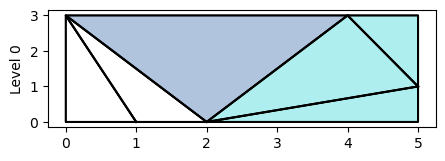

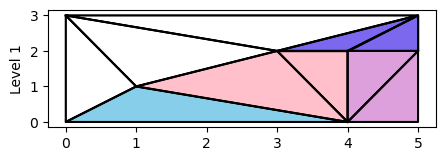

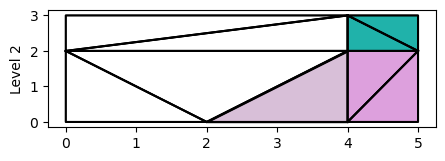

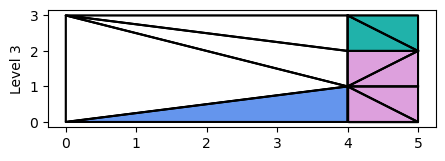

In [72]:
vis_poly(buildings[29])

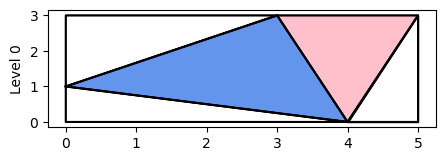

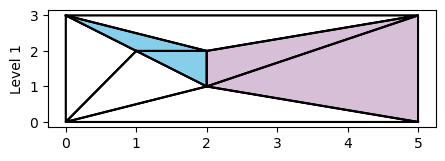

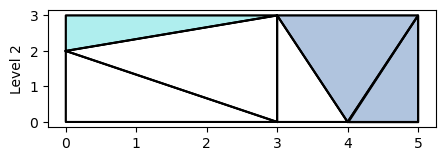

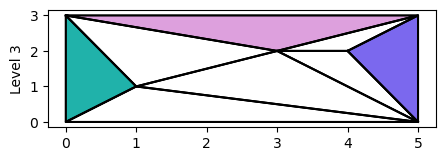

In [73]:
vis_poly(buildings[19])

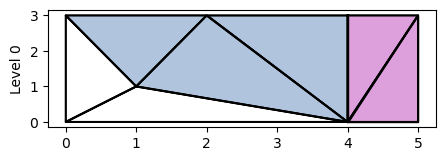

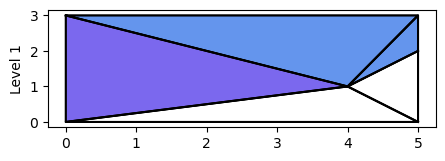

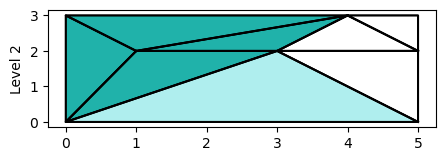

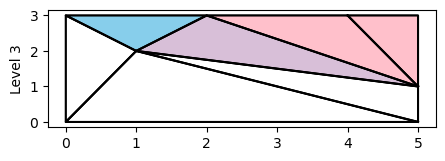

In [74]:
vis_poly(buildings[21])

In [75]:
#n - size of subsample 
#buildings - list of buildings
#heightss - list of heightss
#L - table of distances
def removing_min_div(buildings, heightss, n, r, w0, w1, w2, L):
    
    if len(buildings)!= len(heightss):
        print ("not matching size of set of heights")
        return -1
    if n > len(buildings): 
        print("size of the subset is too big")
        return -2
    
    #Final subset
    ind = []
    for i in range(len(buildings)):
        ind.append(i)
    print(ind, "ind")
    
       
    #sum of distance for each element
    A = []
    for i in ind: 
        A.append(0)
        
    for i in ind:
        A[i] = 0
        for j in ind: 
            A[i] += L[i][j]
    print(A)
    
    
    return sorted(range(len(A)), key=lambda k: A[k])[:n]
        
removing_min_div(buildings, heightss, 3, 1, 1, 1, 1, L)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] ind
[13.445195530000001, 12.78425916, 12.349436690000003, 12.541167659999996, 12.815521870000003, 12.524814250000004, 12.61822538, 13.998998600000004, 12.45352233, 13.0656062, 12.763501080000001, 13.08195624, 14.06846368, 13.106325160000003, 13.183162609999998, 13.456971440000006, 12.424167560000003, 12.468927780000003, 13.11418012, 13.717649319999998, 12.642100730000001, 12.598502049999999, 12.91967562, 13.40528072, 12.644251599999999, 12.47229218, 12.484793910000006, 12.24525442, 13.44226297, 14.1236416]


[27, 2, 16]

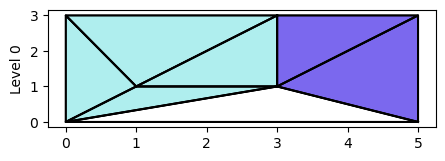

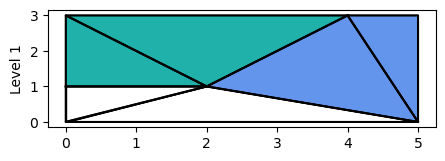

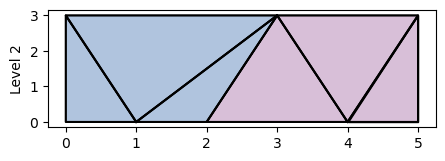

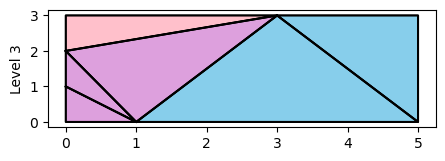

In [76]:
vis_poly(buildings[27])

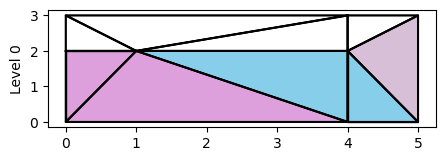

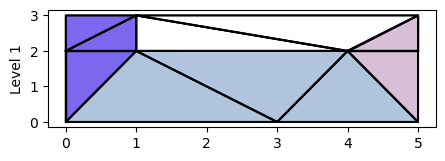

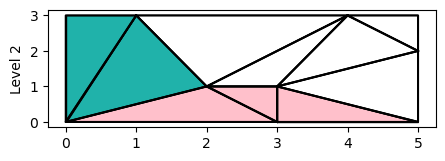

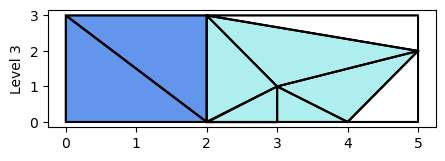

In [77]:
vis_poly(buildings[2])

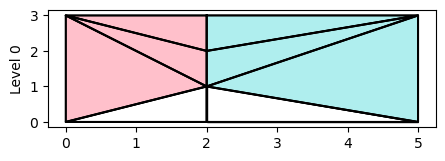

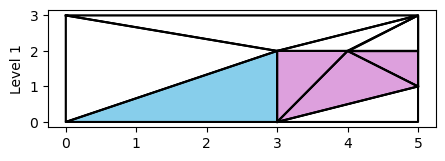

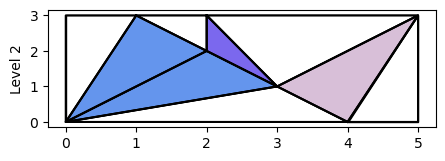

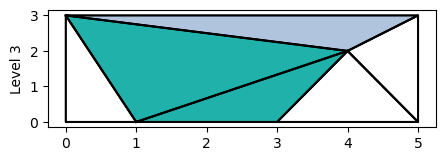

In [78]:
vis_poly(buildings[16])

## Clustering

In [79]:
clustering = AgglomerativeClustering(n_clusters=5, metric='precomputed', linkage='complete', compute_distances = True).fit(L)
clustering

AgglomerativeClustering(compute_distances=True, linkage='complete',
                        metric='precomputed', n_clusters=5)

In [80]:
clustering.labels_

array([0, 0, 0, 3, 0, 2, 3, 1, 2, 2, 0, 2, 4, 0, 2, 0, 0, 0, 0, 3, 0, 2,
       0, 2, 0, 2, 2, 2, 2, 1])

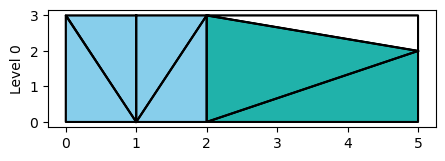

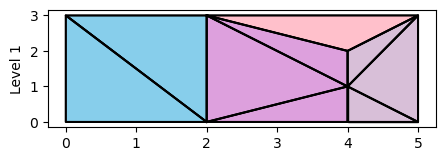

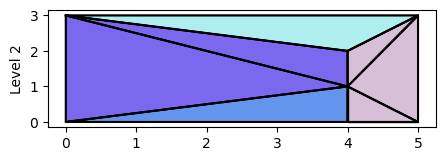

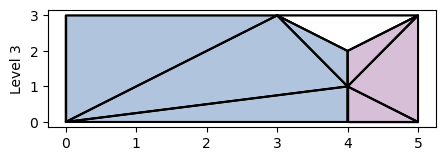

In [81]:
vis_poly(buildings[7])

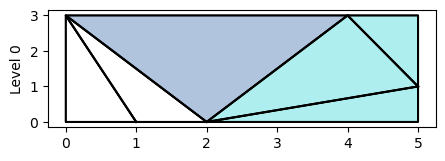

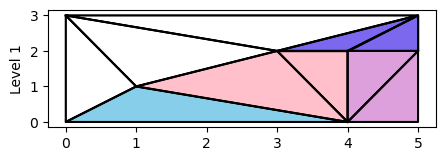

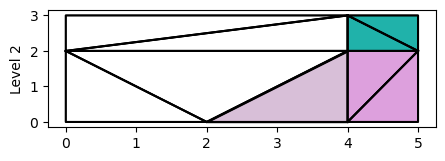

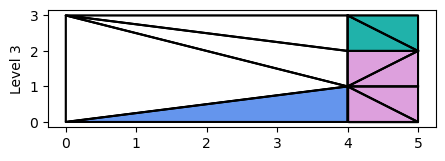

In [82]:
vis_poly(buildings[29])

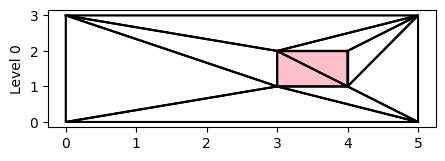

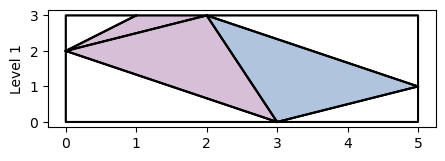

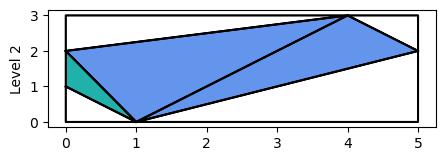

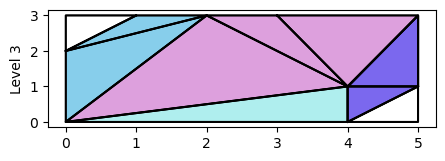

In [83]:
vis_poly(buildings[12])

In [84]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

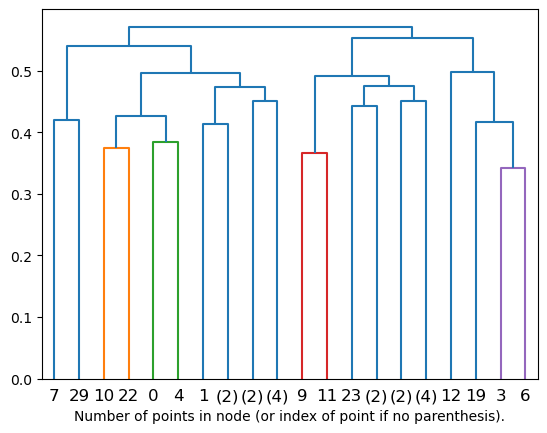

In [85]:
plot_dendrogram(clustering, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()